In [ ]:
!python -m pip install glob2

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import obspy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import glob

from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

In [2]:
def calculate_performance_metrics(on_off, tr_times, known_arrival_time, buffer=150.0):
    """
    Calculate whether the detected triggers match the known arrival time
    within a specified buffer before the known arrival.
    """
    # Check if on_off is empty
    if len(on_off) == 0:  # If no triggers were found
        return 0, 0, 1  # No true positives, no false positives, one false negative

    # Extract trigger on times (assuming on_off has the indices of trigger onsets)
    trigger_on_times = tr_times[on_off]
    
    # Initialize counts
    true_positive = 0
    false_positive = 0
    false_negative = 0

    # Check if the known arrival time is captured by any trigger within the buffer before it
    for trigger_time in trigger_on_times:
        pre_buffer = known_arrival_time - buffer
        post_buffer = known_arrival_time + buffer
        if ((trigger_time[0] >= pre_buffer) & (trigger_time[0] <= post_buffer)):
            true_positive += 1
            break  # No need to check further if we found a true positive

    if true_positive == 0:
        false_negative += 1  # If no true positive found, it's a false negative

    # Calculate false positives
    false_positive = len(trigger_on_times) - true_positive

    return true_positive, false_positive, false_negative

In [3]:
def plot_seismograph(tr_times, tr_data, date):
    """Generic, standard seismograph to visualize earthquake waves"""
    # Initialize figure
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times,tr_data)
    
    # Make the plot pretty
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (Relative)')
    ax.set_title(f'Seismograph for {date}')#{datetime.strftime(arrival_time, "%d %B, %Y")}')

def plot_characteristics(cft, tr_times, date, planet):
    """Characteristics derrived from short term/long term average"""
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times,cft)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel('Time (Relative)')
    ax.set_ylabel('Characteristic function')
    ax.set_title(f'{planet} Seismic Characteristics for {date}')

def plot_predictions_metrics(on_off, tr_times, tr_data, date, metrics, arrival, planet):
    """The generic seismograph with the predicted earthquake starts plotted"""
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        ax.axvline(x = tr_times[triggers[0]], color='red', label='Event Start Time Prediction', zorder=2)

    ax.axvline(arrival, color="cyan", label="True Arrival", zorder=3)
    
    # Plot seismogram
    ax.plot(tr_times,tr_data, zorder=1)
    ax.set_ylabel("Velocity m/s")
    ax.set_xlabel("Time (Relative)")
    ax.set_title(f'{planet} Seismic Event Predictions for {date} - Metrics: {metrics} (tp, fp, fn)')
    ax.set_xlim([min(tr_times),max(tr_times)])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')


def plot_predictions_no_metrics(on_off, tr_times, tr_data, date, planet):
    """The generic seismograph with the predicted earthquake starts plotted"""
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    for i in np.arange(0,len(on_off)):
        triggers = on_off[i]
        ax.axvline(x = tr_times[triggers[0]], color='red', label='Event Start Time Prediction', zorder=2)
    
    # Plot seismogram
    ax.plot(tr_times,tr_data, zorder=1)
    ax.set_ylabel("Velocity m/s")
    ax.set_xlabel("Time (Relative)")
    ax.set_title(f'{planet} Seismic Waves Recorded and Event Predictions for {date}')
    ax.set_xlim([min(tr_times),max(tr_times)])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')

def plot_spectrogram(tr, tr_data, tr_times, arrival=""):
    from scipy import signal
    from matplotlib import cm
    f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)
    
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    vals = ax.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-18)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
    ax.set_ylabel('Frequency (Hz)', fontweight='bold')
    if arrival != "":
        ax.axvline(x=arrival, c='red')
    cbar = plt.colorbar(vals, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

In [4]:
def cft_windows(tr, tr_data, sta_len=120, lta_len=600):
    """designates the window size (in seconds) for short/long term,
    and calculates the ratio of amplitude between the windows"""
    # Sampling frequency of our trace
    df = tr.stats.sampling_rate
    
    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))
    return cft

In [5]:
def run_Lunar_Training_Predictions(directory, files, i, planet, plot_spec=False, plot_char=False):
    row = files.iloc[i]
    current_file = row.filename
    mseed_file = f'{directory}{current_file}.mseed'
    
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    st = obspy.read(mseed_file)
    
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    date = obspy.UTCDateTime.strftime(tr.stats.starttime,'%d %B, %Y')
    
    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    arrival = (arrival_time - starttime).total_seconds()
    
    # Set the minimum frequency
    minfreq = 0.5
    maxfreq = 1.0
    
    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    
    cft = cft_windows(tr, tr_data)
    
    # Plot characteristic function
    if plot_char == True:
        plot_characteristics(cft, tr_times, date, planet)
    
    # Play around with the on and off triggers, based on values in the characteristic function
    thr_on = cft.max()-1.5
    thr_off = thr_on - 1.5
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    
    # The first column contains the indices where the trigger is turned "on". 
    # The second column contains the indices where the trigger is turned "off".
    metrics = calculate_performance_metrics(on_off, tr_times, arrival, buffer=(tr_times.max()*0.01))
    # print(f'metrics for {plot_num}: {metrics}')

    # Plot on and off triggers
    plot_predictions_metrics(on_off, tr_times, tr_data, date, metrics, arrival, planet)

    if plot_spec == True:
        plot_spectrogram(tr, tr_data, tr_times, arrival)

In [6]:
def run_Lunar_Predictions(m_file, planet, plot_spec=False, plot_char=False, plot_seis=False):
    st = obspy.read(m_file)
    
    tr = st.traces[0].copy()

    tr_times = tr.times()
    tr_data = tr.data
    date = obspy.UTCDateTime.strftime(tr.stats.starttime,'%d %B, %Y')
    
    if plot_seis == True:
        plot_seismograph(tr_times, tr_data, date, planet)
    
    # Set the minimum frequency
    minfreq = 0.5
    maxfreq = 1.0
    
    # Going to create a separate trace for the filter data
    st_filt = st.copy()
    st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
    tr_filt = st_filt.traces[0].copy()
    tr_times_filt = tr_filt.times()
    tr_data_filt = tr_filt.data
    
    cft = cft_windows(tr, tr_data)

    # Plot characteristic function
    if plot_char == True: 
        plot_characteristics(cft, tr_times, date, planet)

    # Play around with the on and off triggers, based on values in the characteristic function
    thr_on = cft.max() - 1.5
    thr_off = thr_on - 1.5
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # Plot on and off triggers
    plot_predictions_no_metrics(on_off, tr_times, tr_data, date, planet)

    if plot_spec == True:
        plot_spectrogram(tr, tr_data, tr_times)

# Lunar S12 Grade A (Training Data)

/tmp/ipykernel_7107/160865586.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,1,figsize=(12,3))


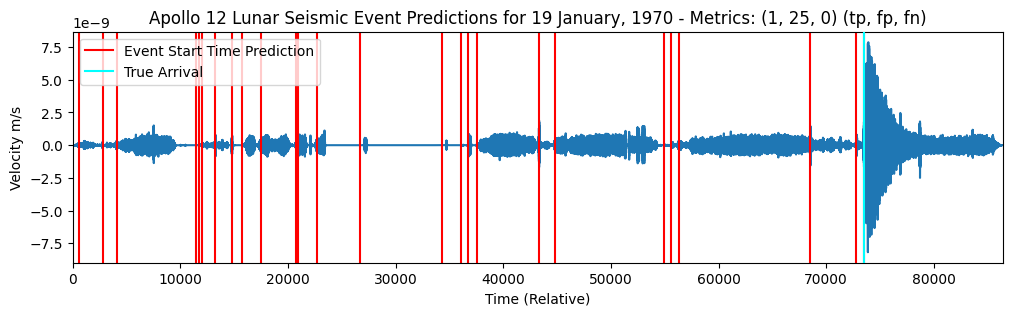

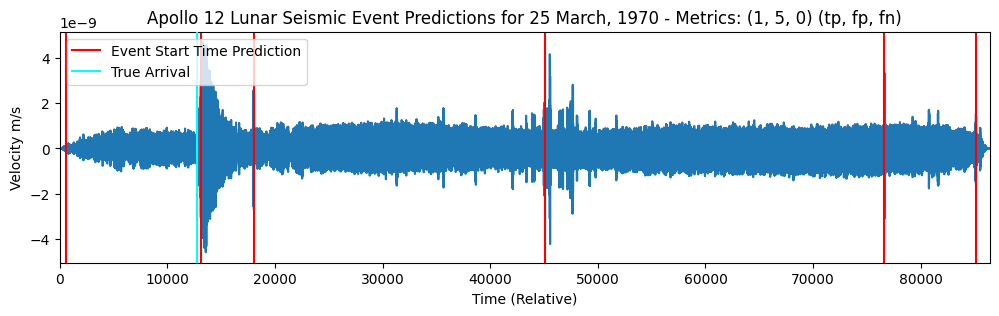

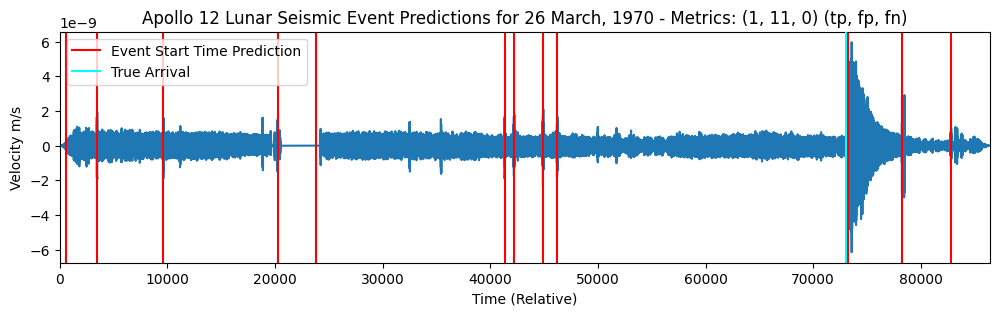

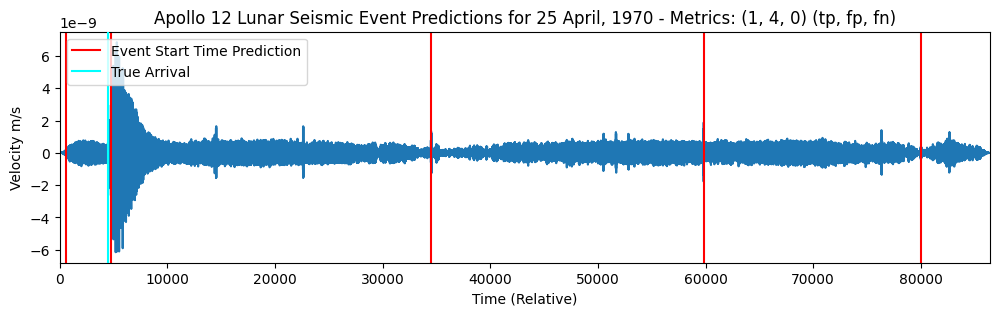

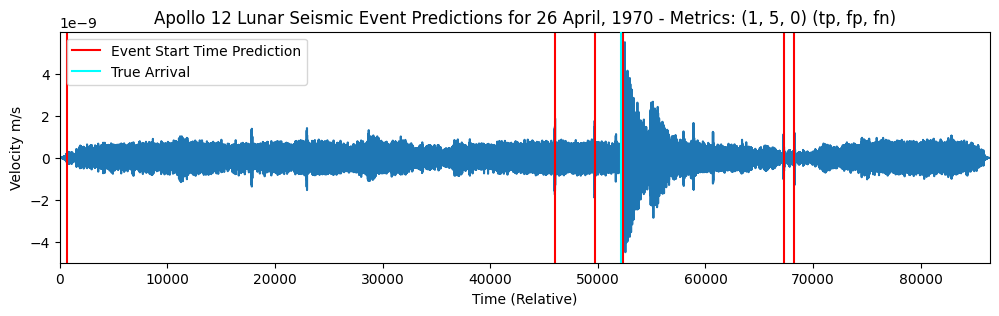

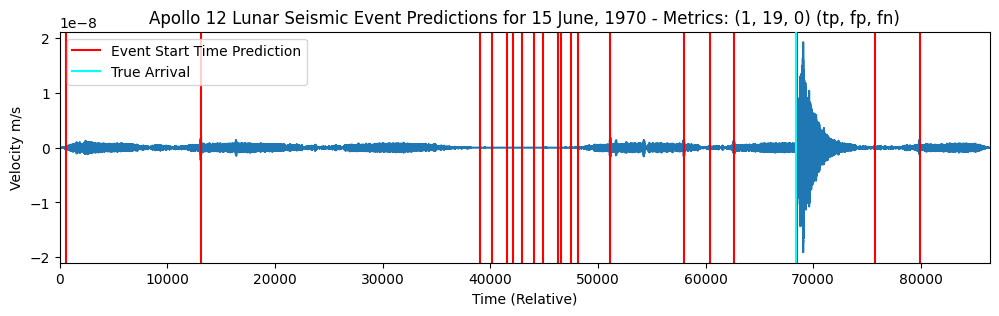

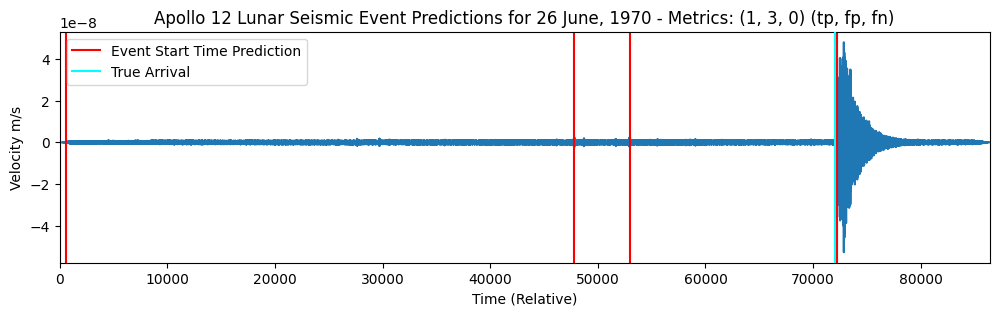

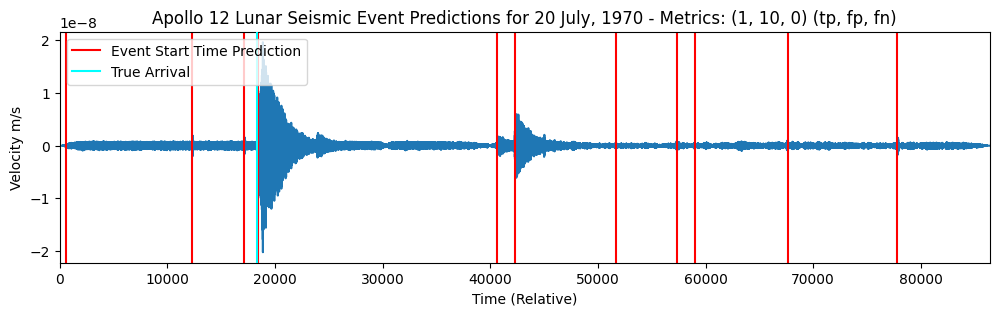

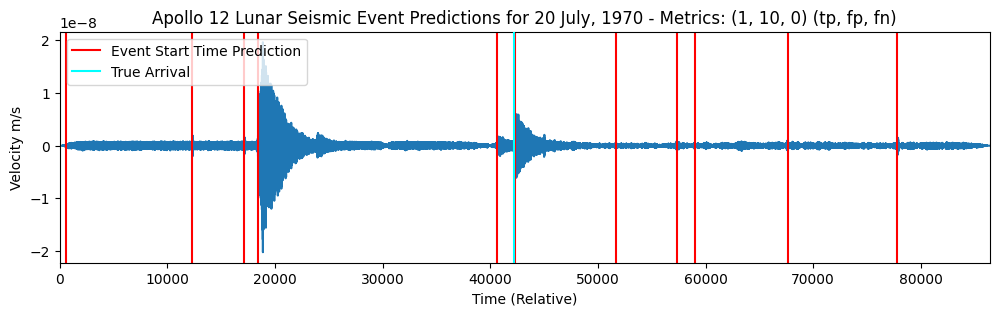

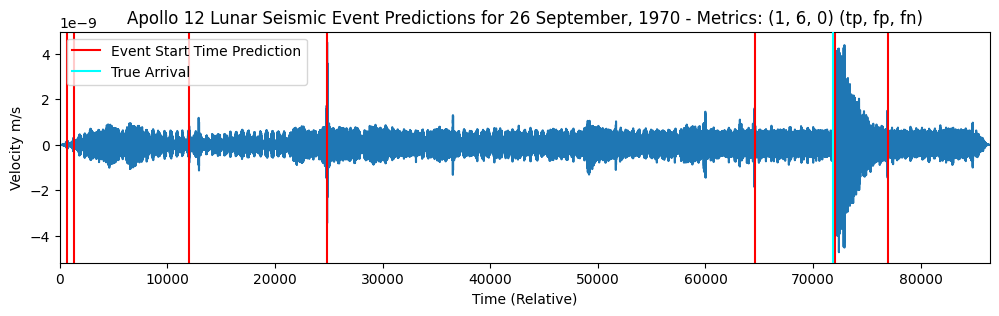

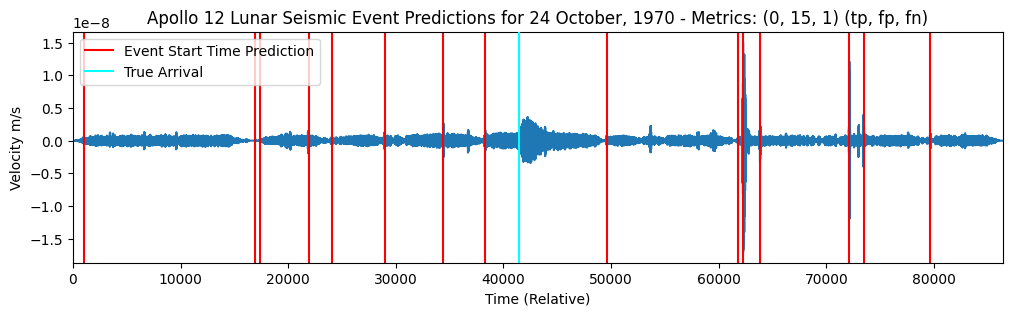

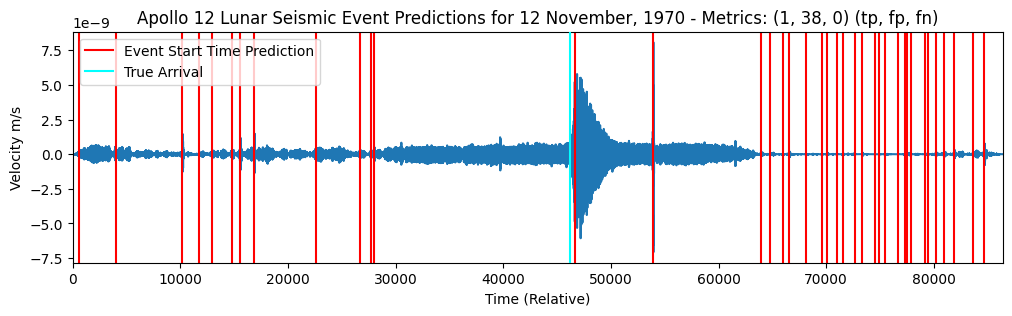

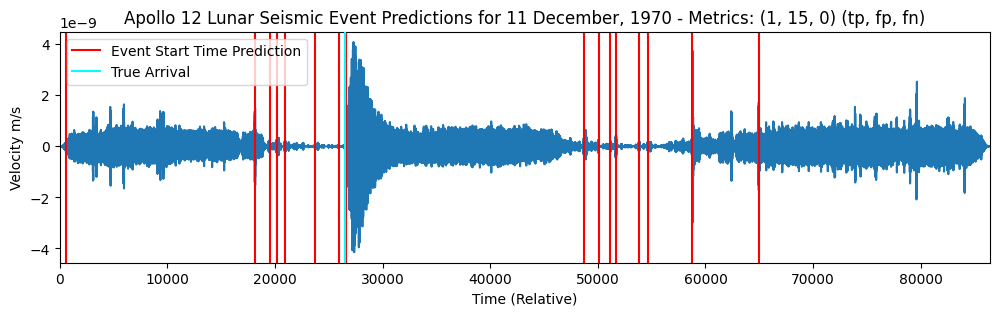

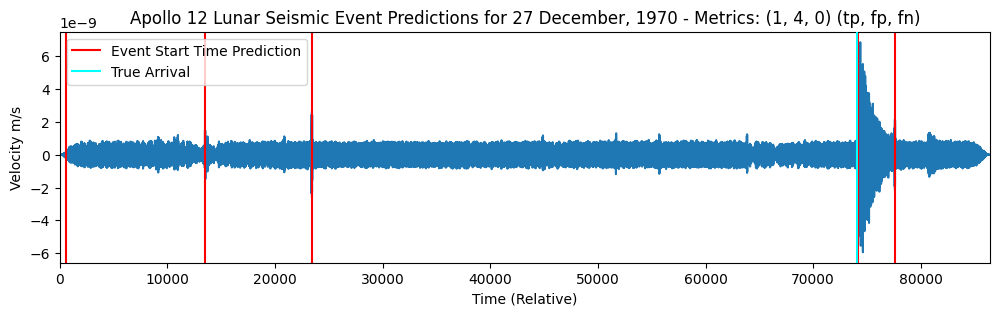

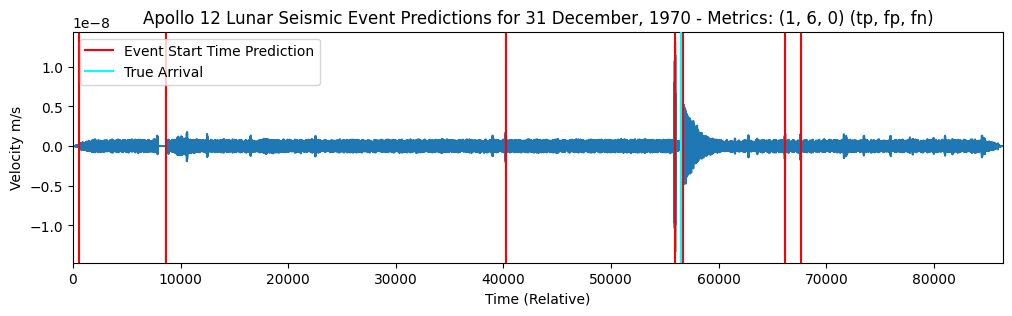

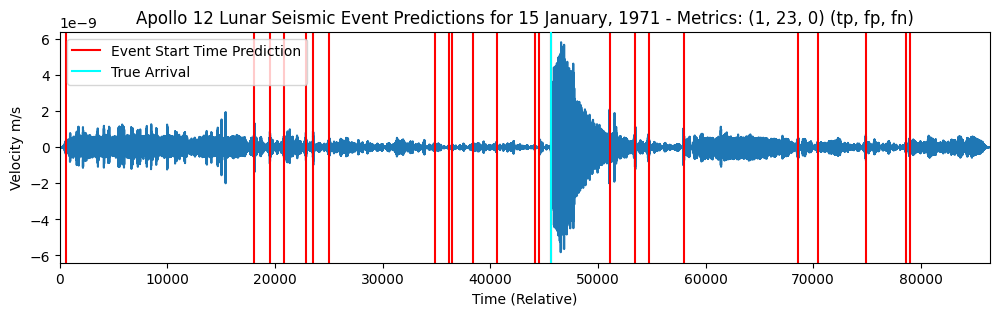

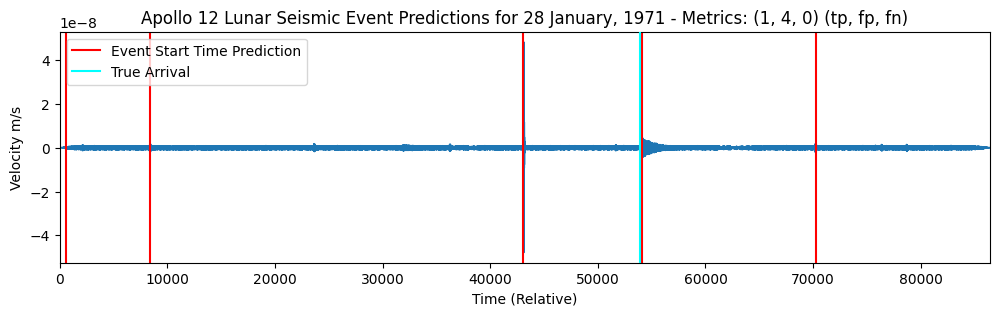

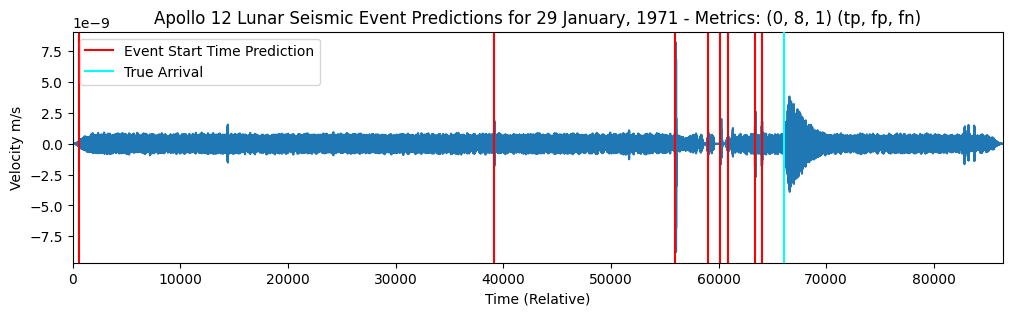

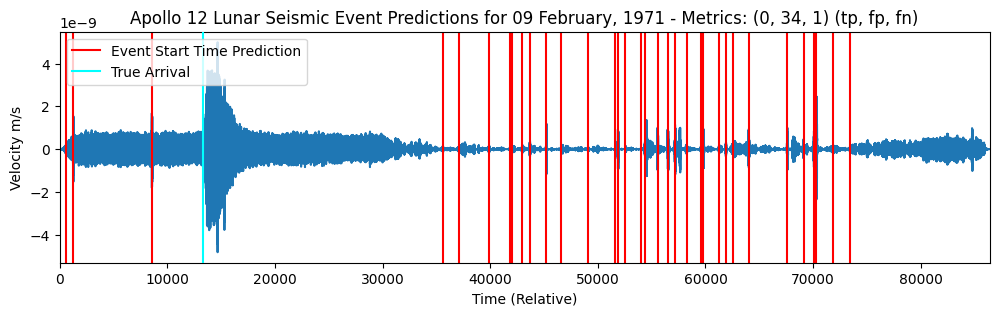

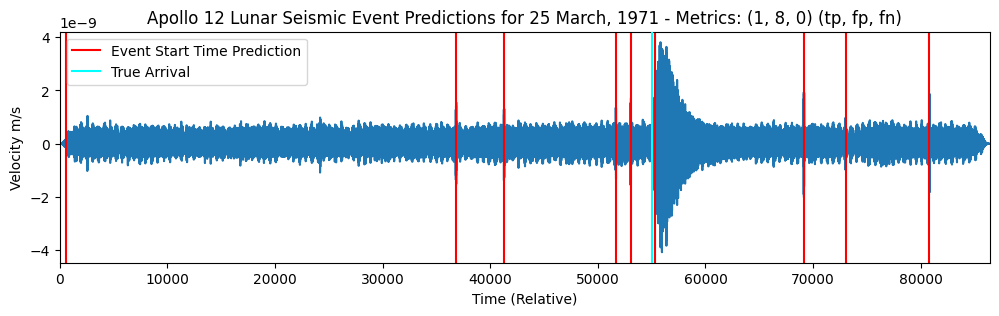

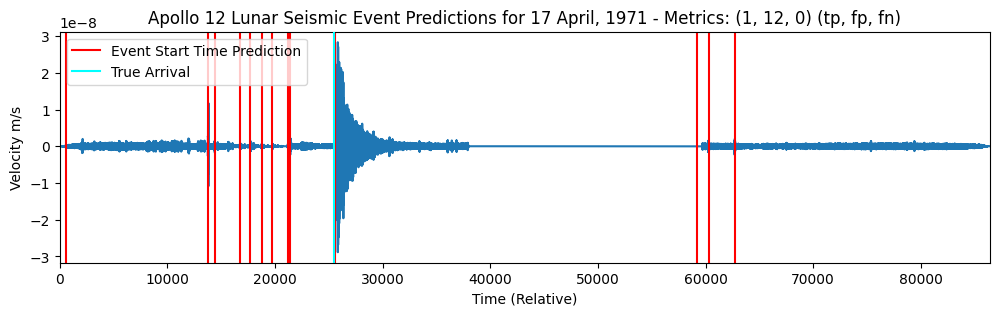

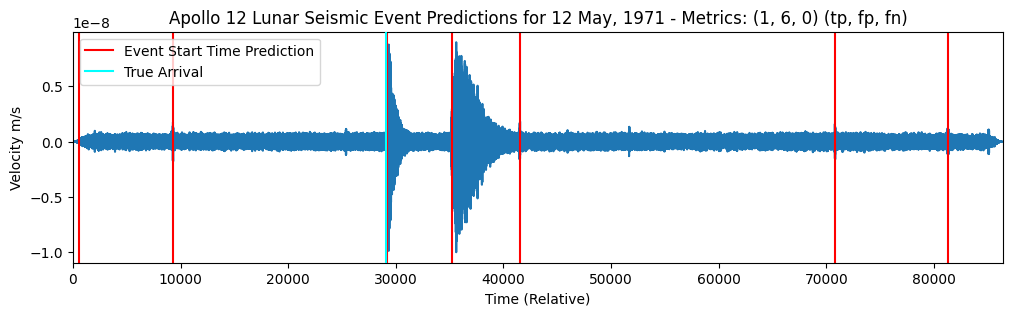

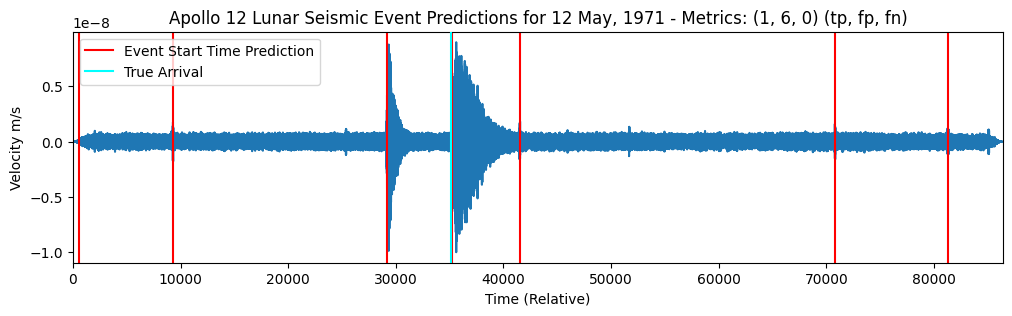

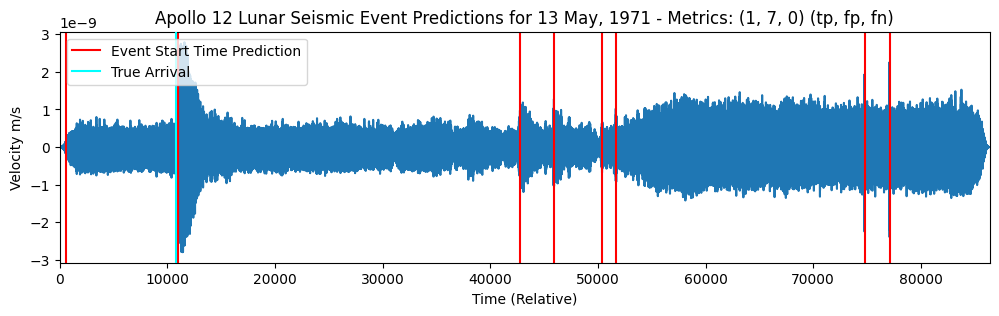

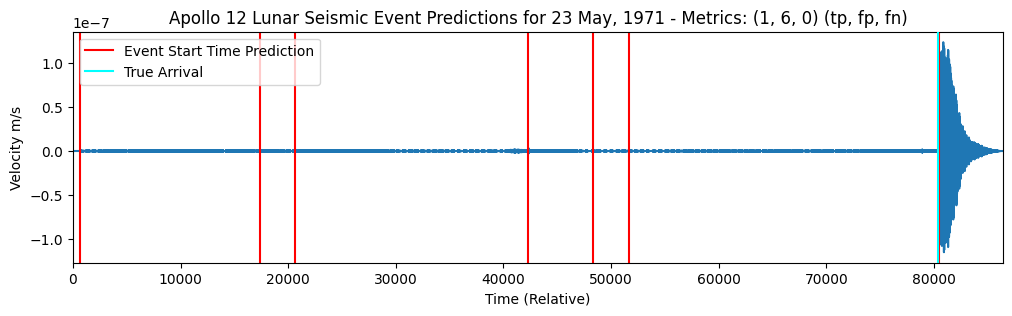

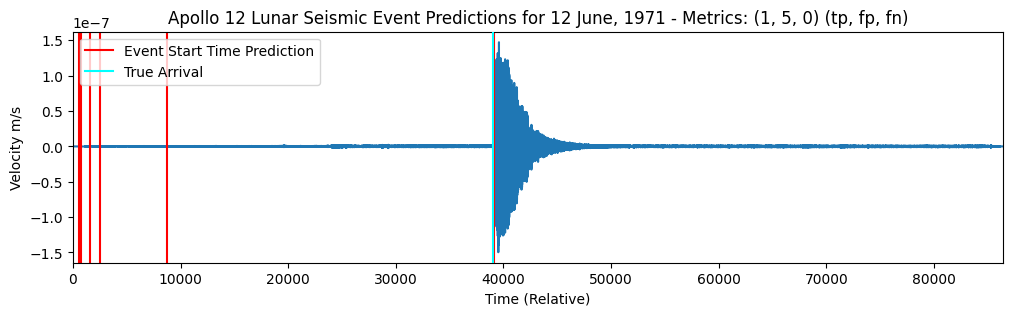

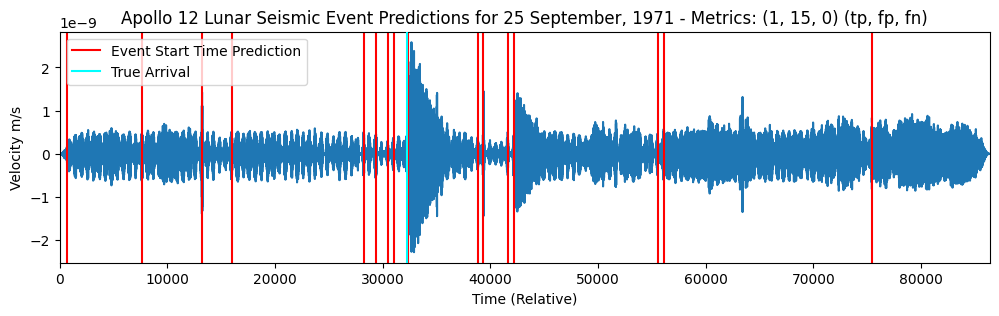

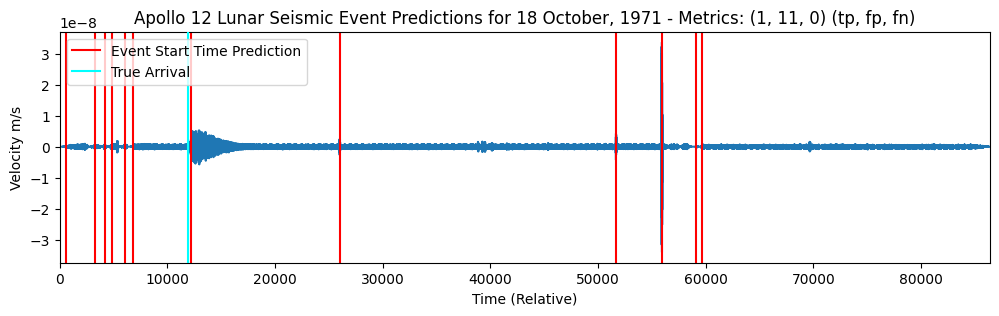

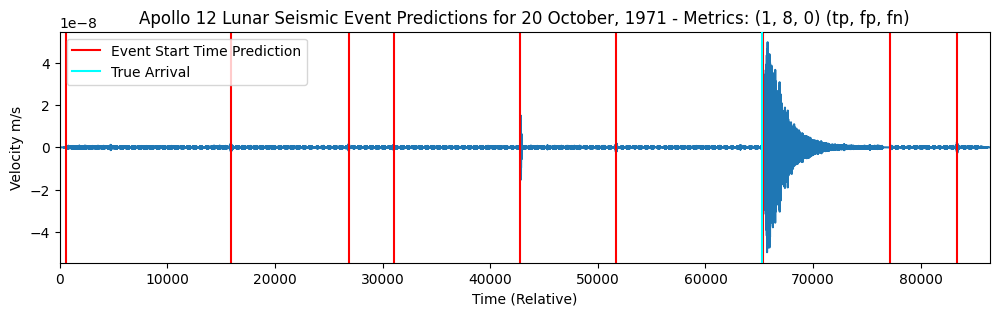

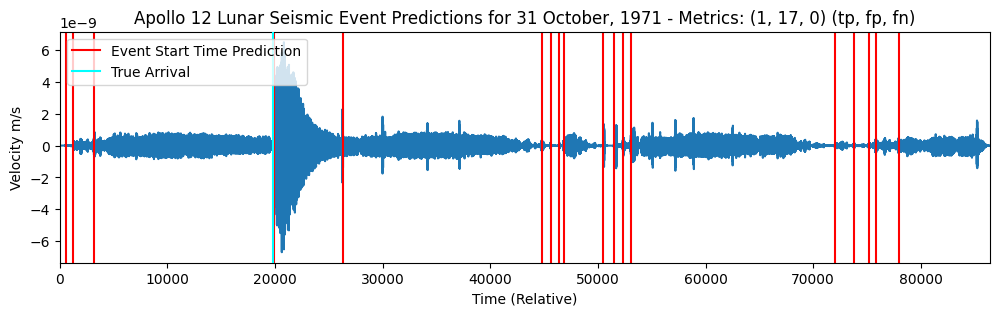

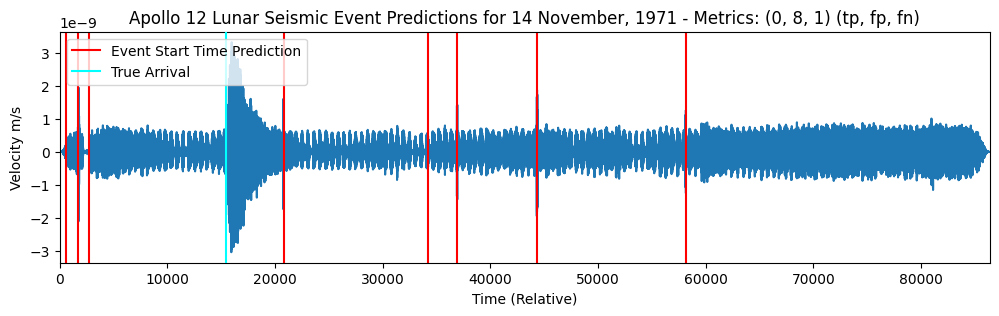

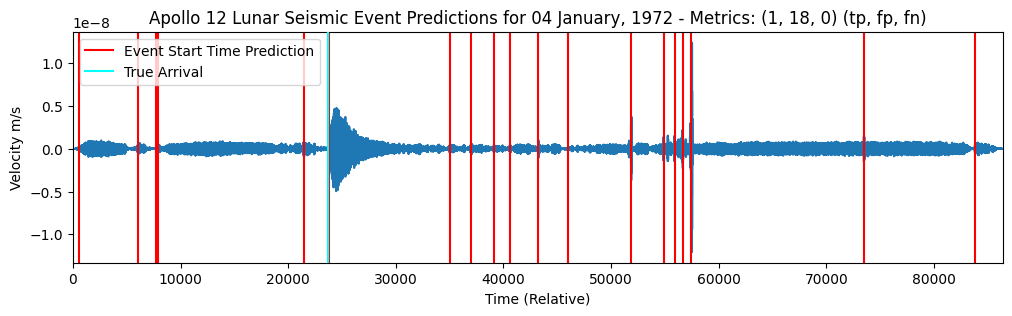

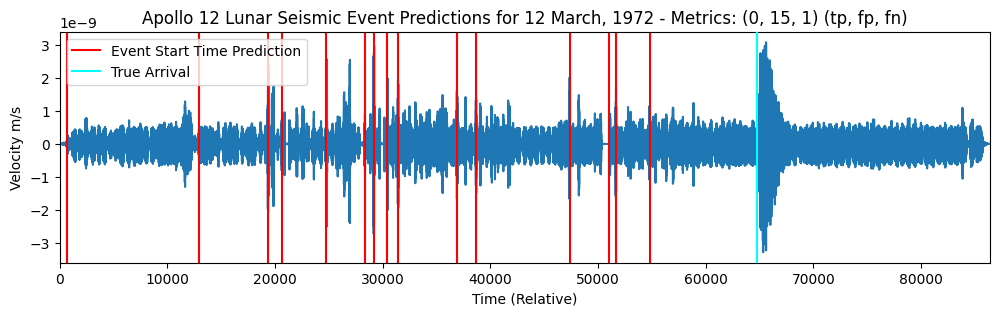

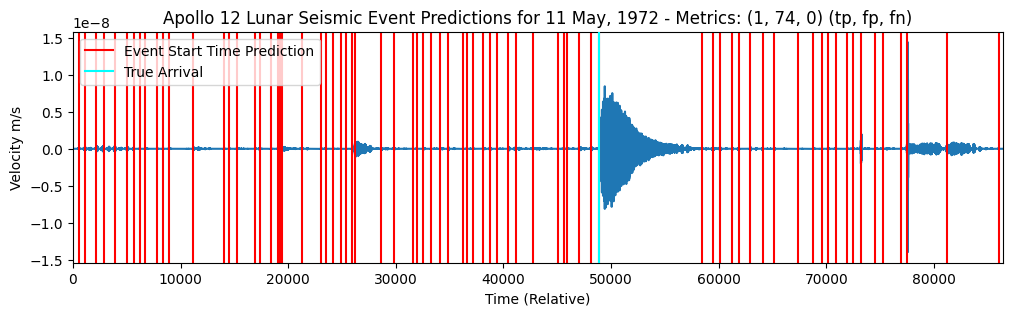

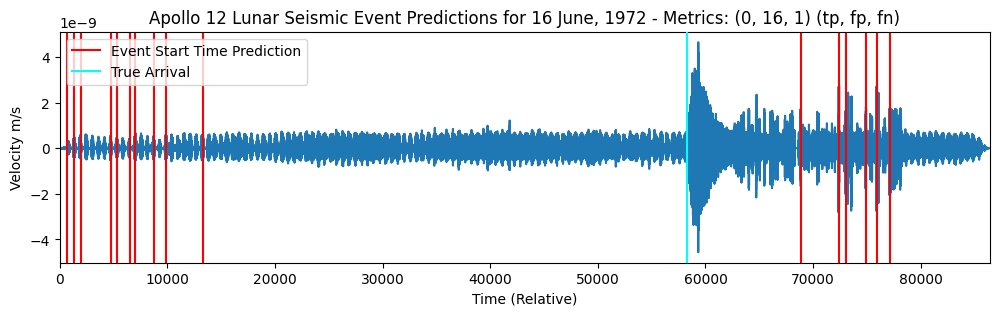

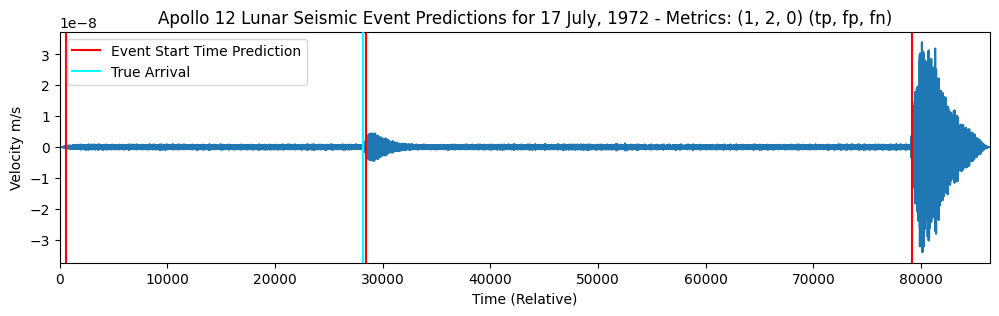

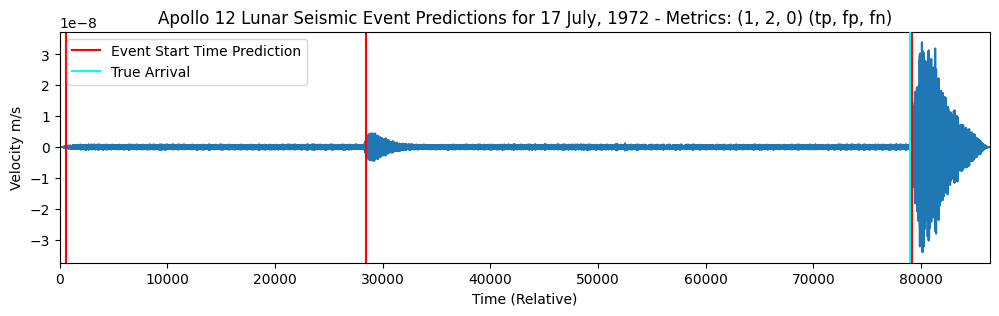

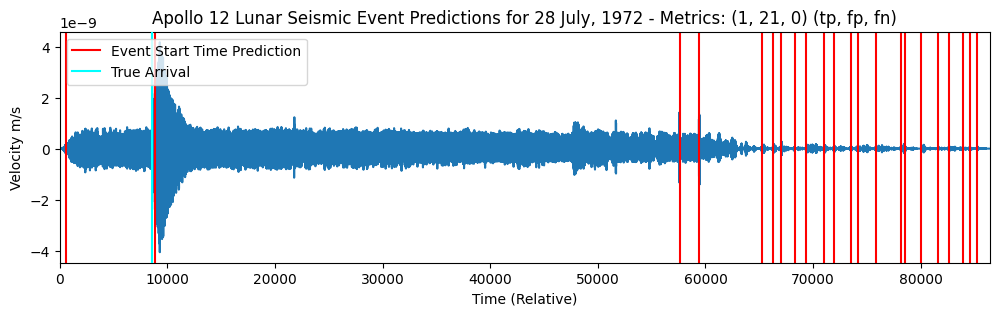

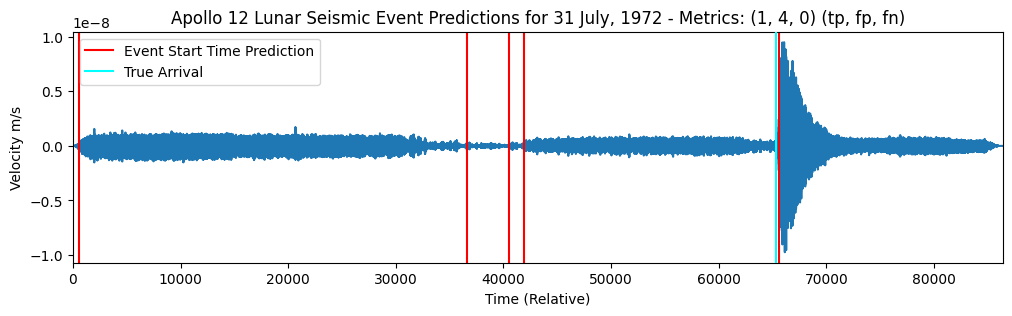

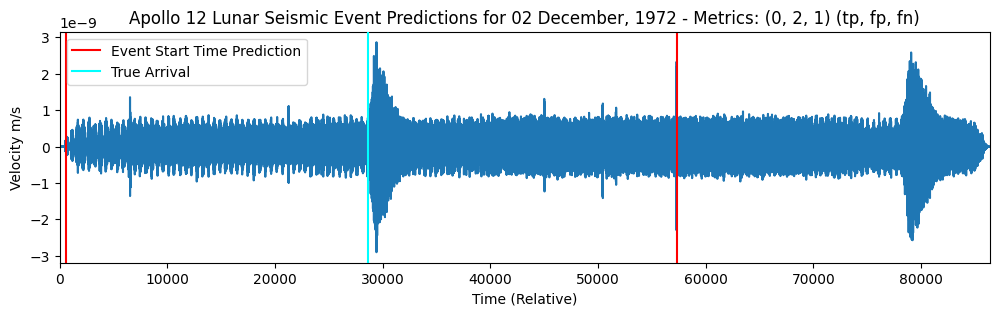

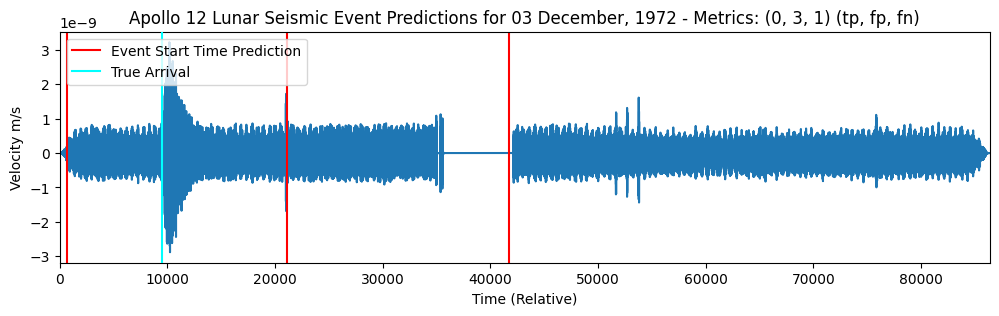

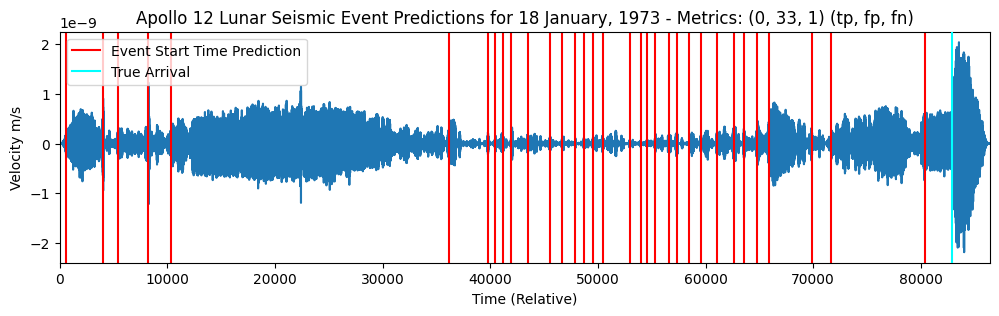

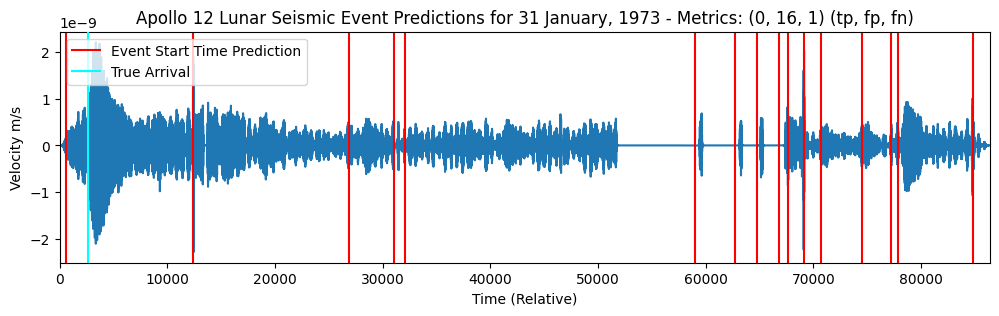

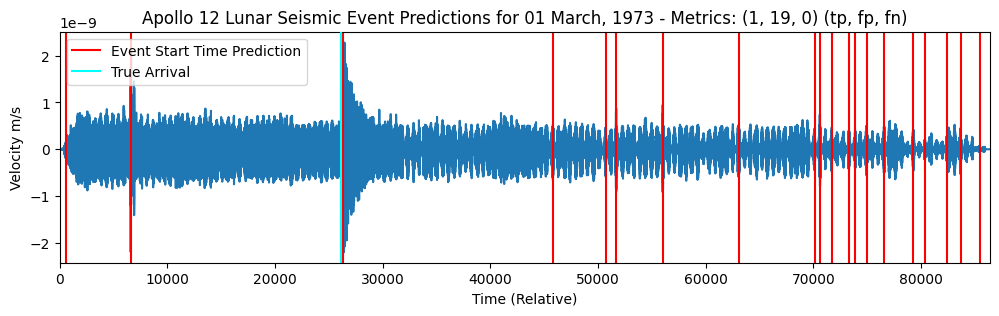

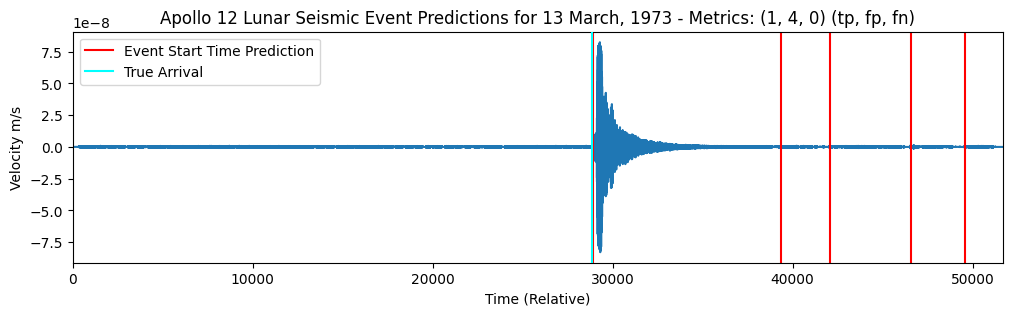

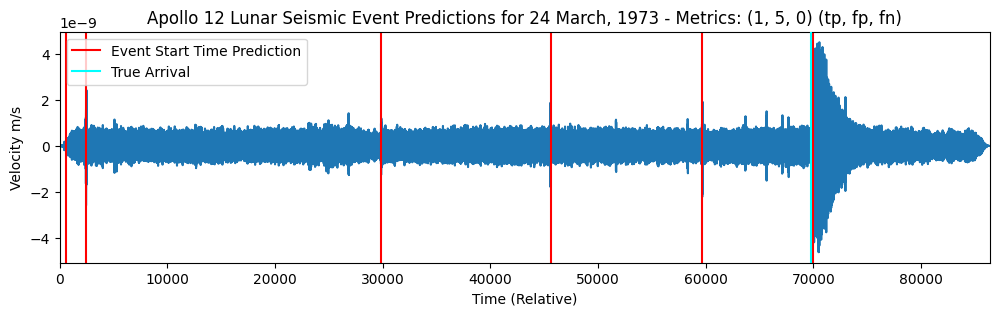

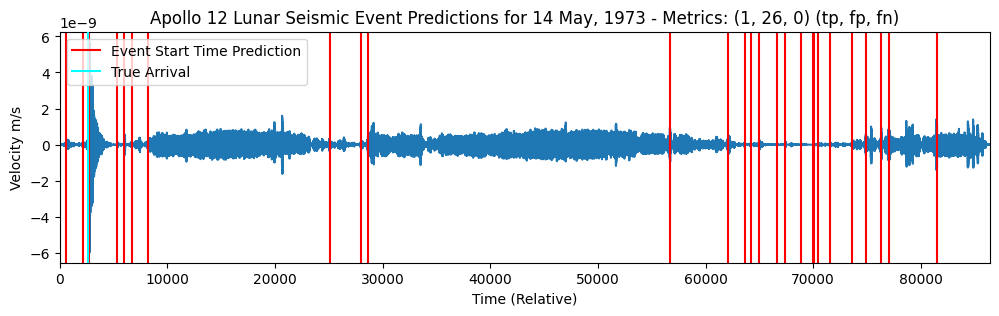

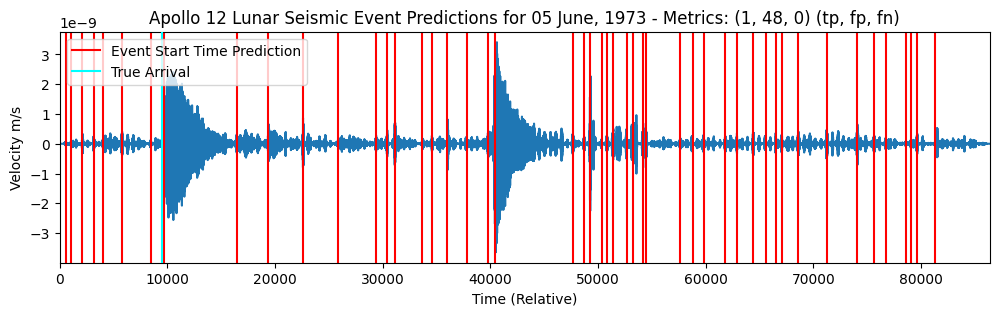

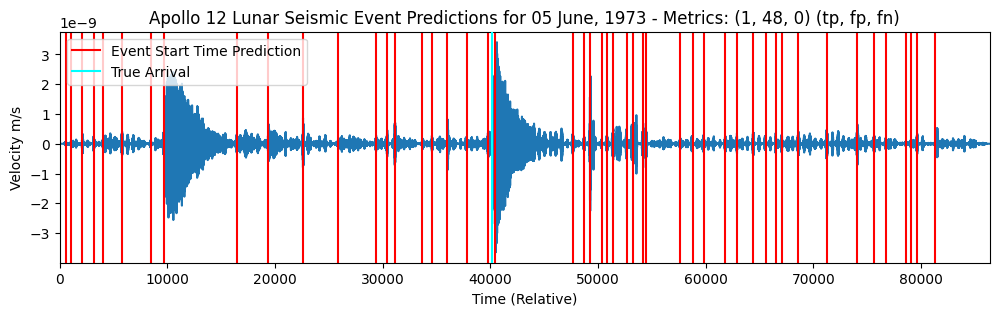

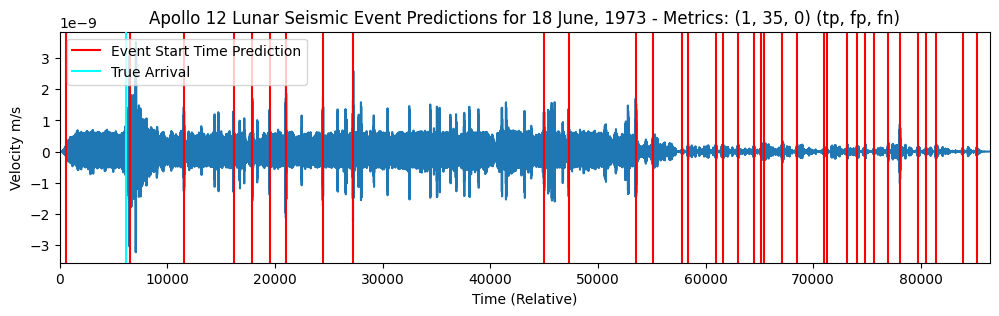

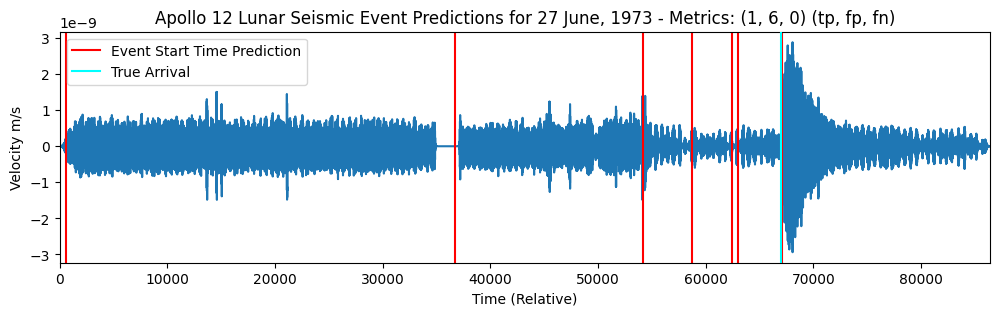

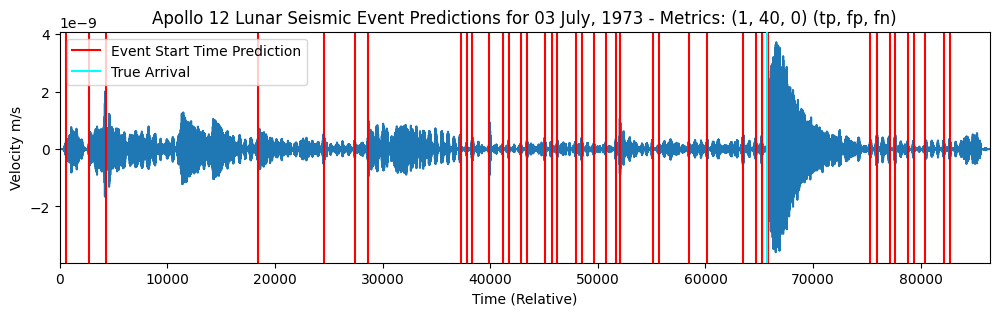

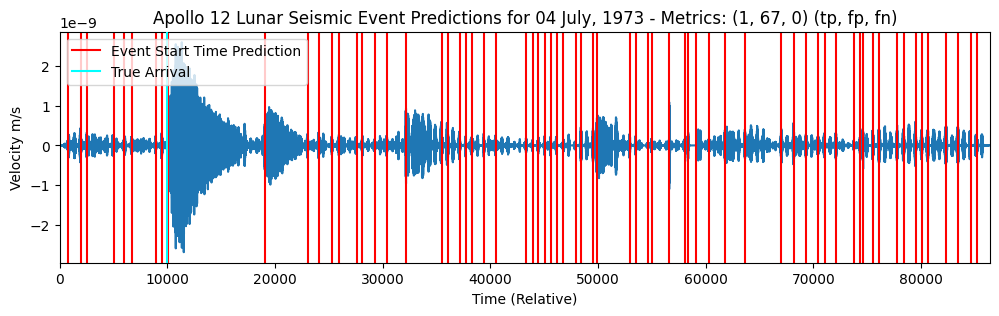

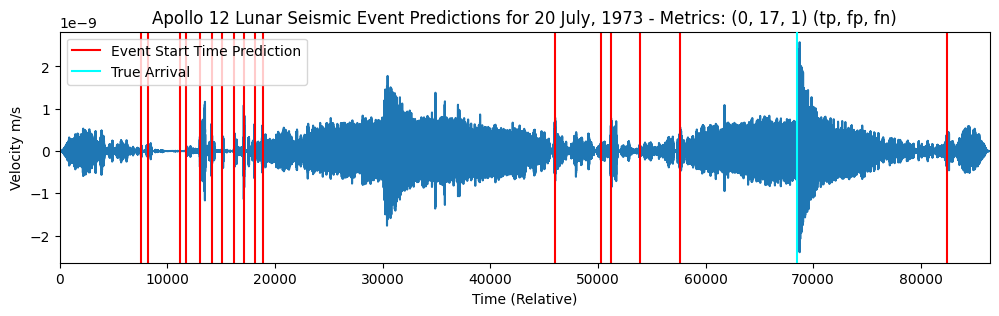

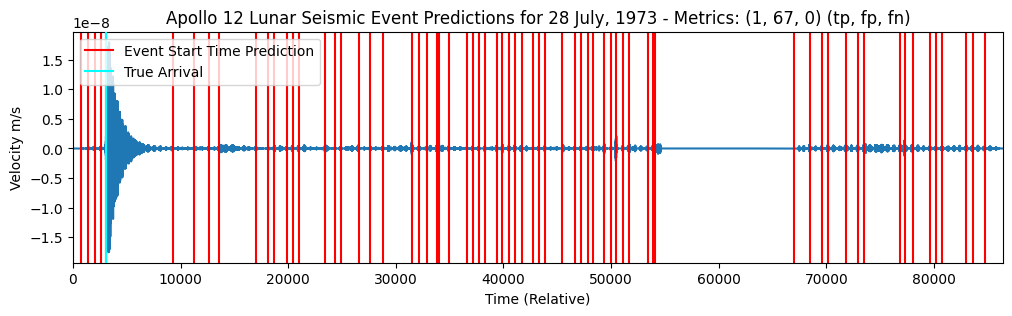

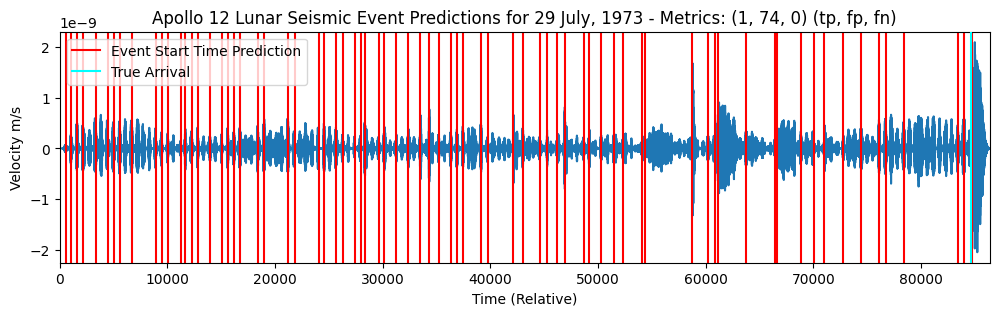

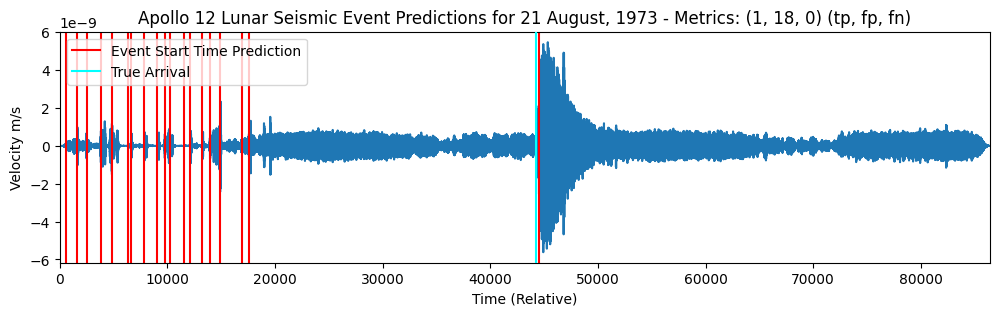

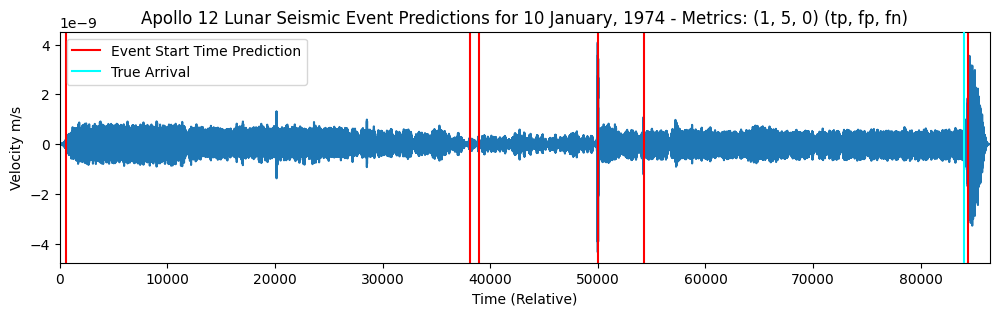

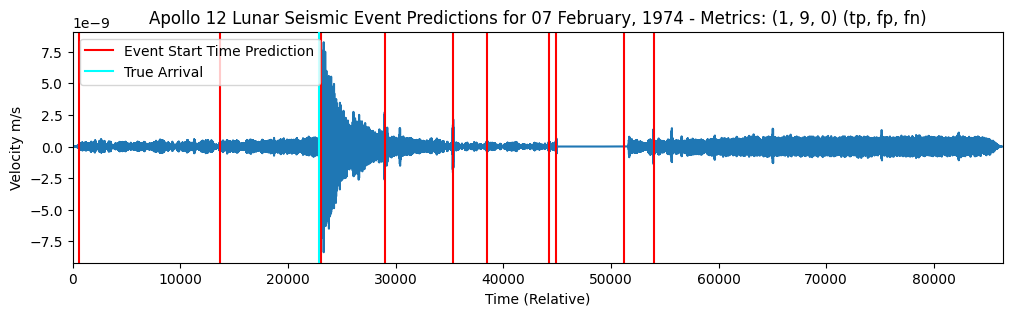

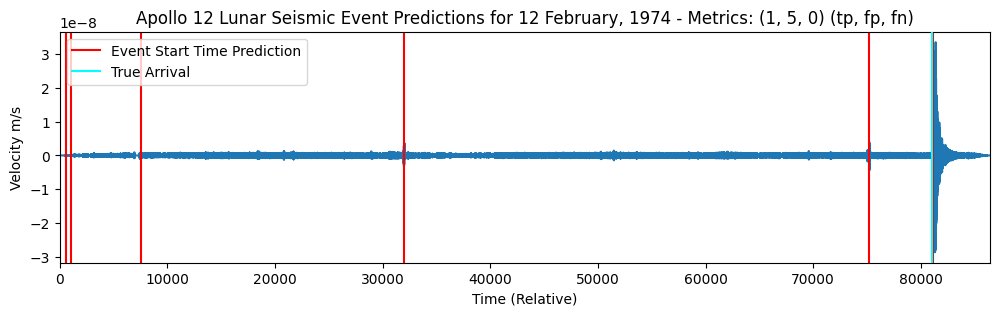

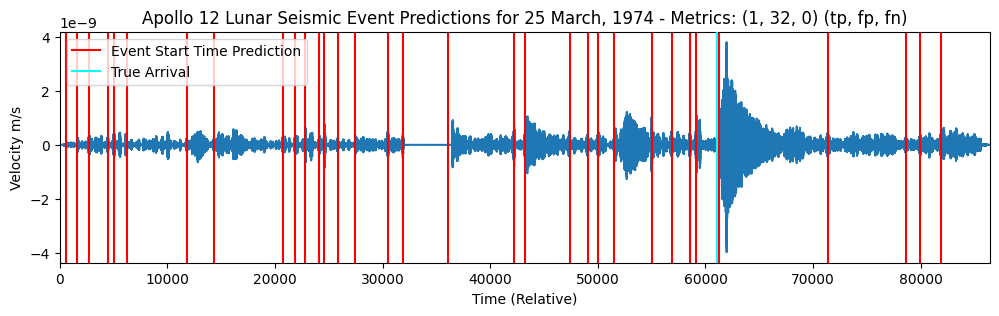

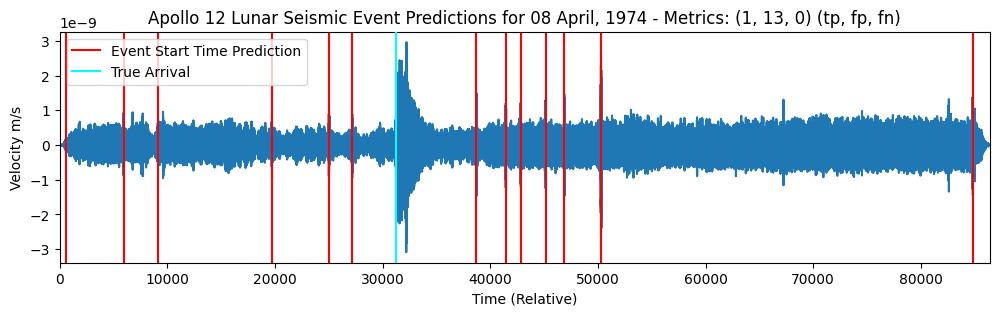

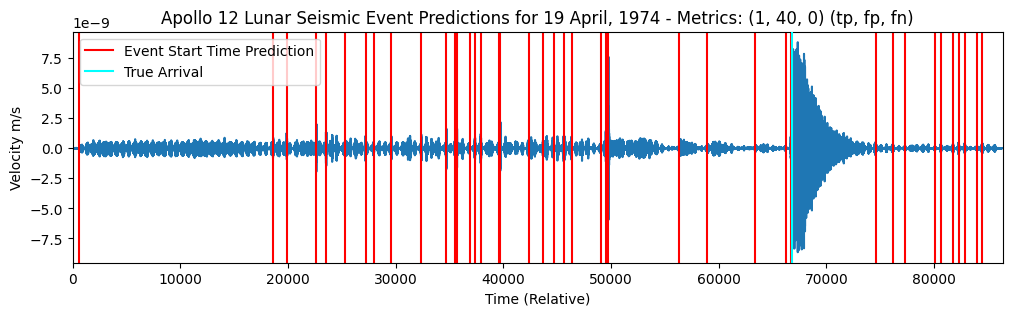

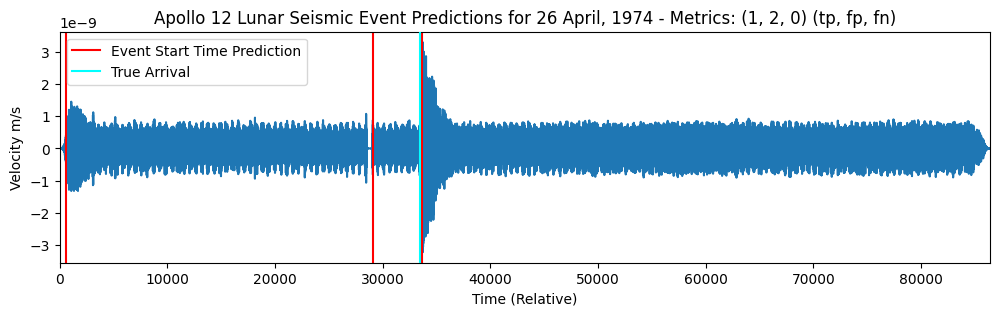

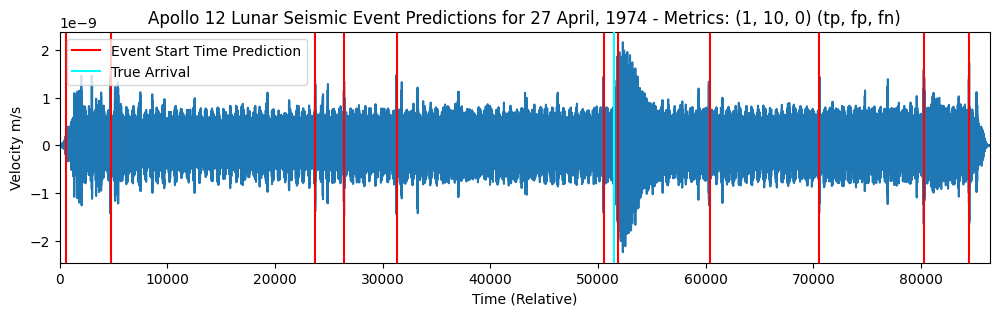

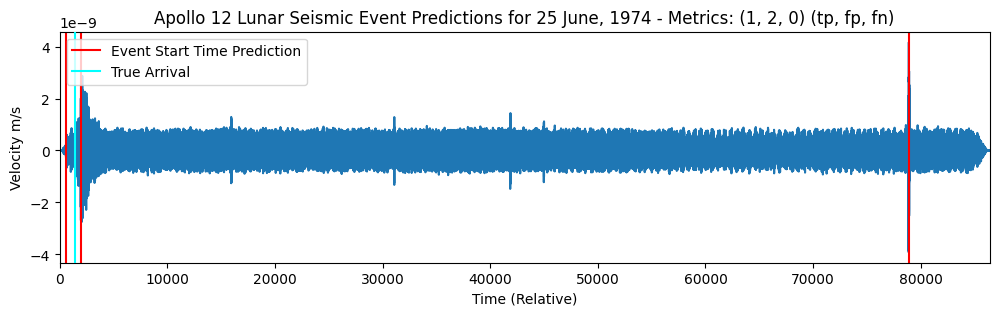

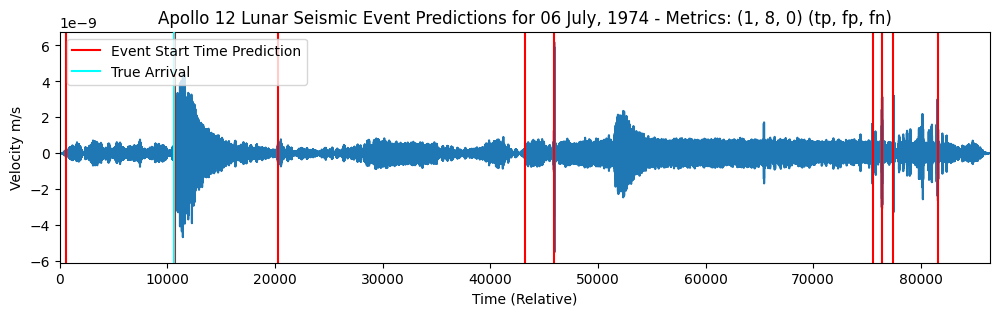

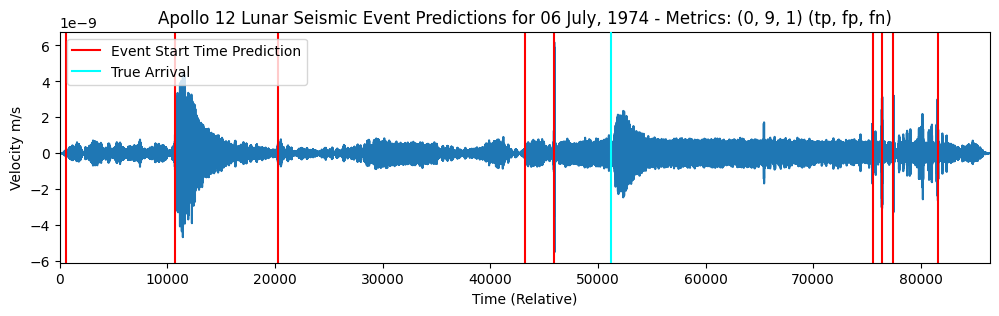

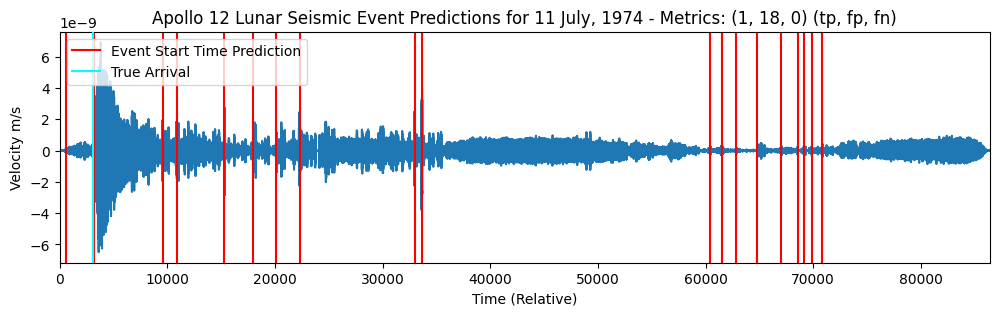

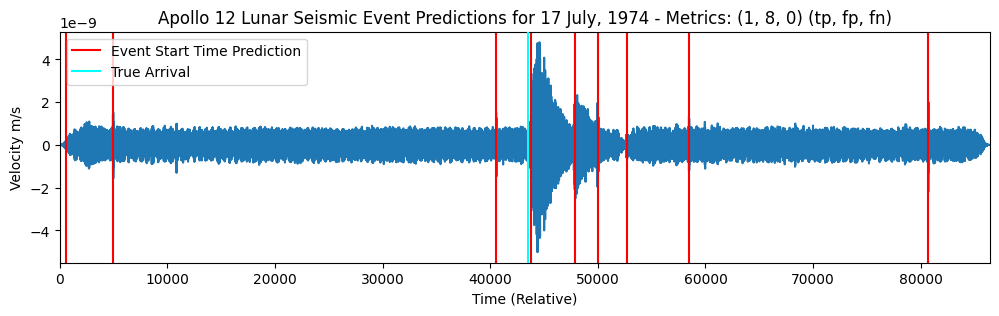

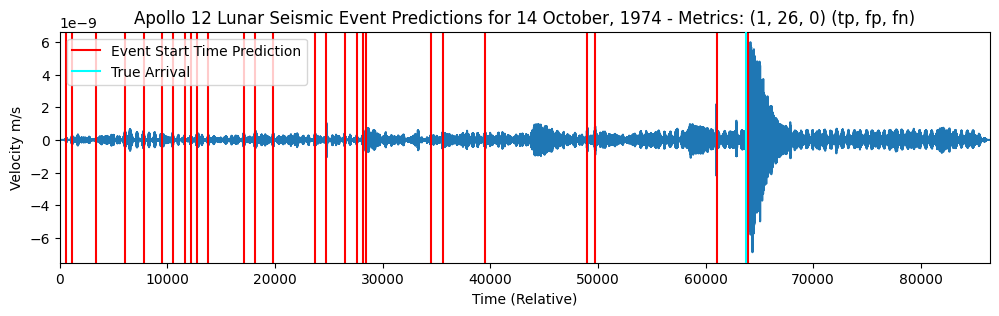

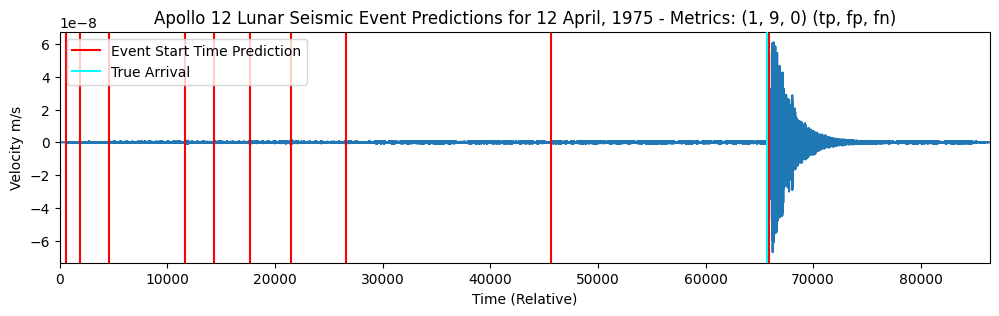

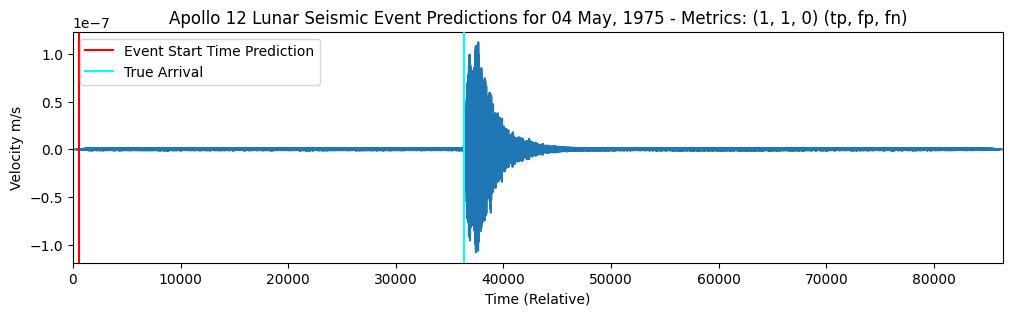

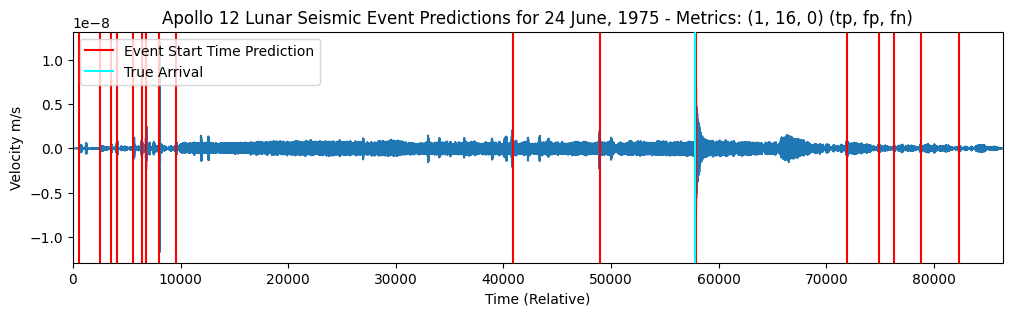

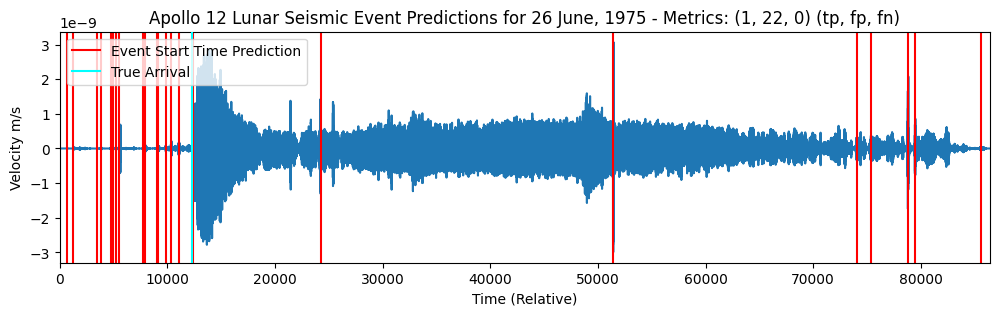

In [7]:
"""This directs to the download location of where the NASA data supplied on the resouces page of 
the challenge is saved. There is where it is saved for me, but the data can be found at:
https://www.spaceappschallenge.org/nasa-space-apps-2024/challenges/seismic-detection-across-the-solar-system/?tab=resources
or directly as a download at:
https://wufs.wustl.edu/SpaceApps/data/space_apps_2024_seismic_detection.zip """

cat_directory = '/app/src/space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cats = pd.read_csv(cat_file)

lunar_training_data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'

for i in range(len(cats)):
    try:
        run_Lunar_Training_Predictions(lunar_training_data_directory, cats, i, "Apollo 12 Lunar")
    except:
        pass
        # print(f"Uh-uh-uh, you didn't say the magic word (index {i})")

# Lunar S12 Grade B - Big

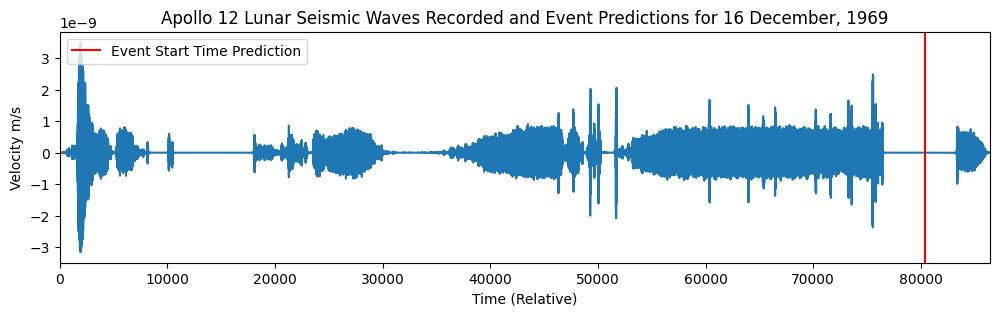

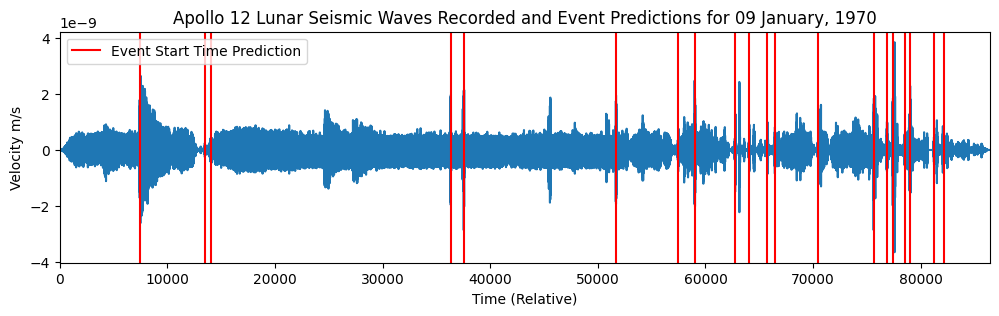

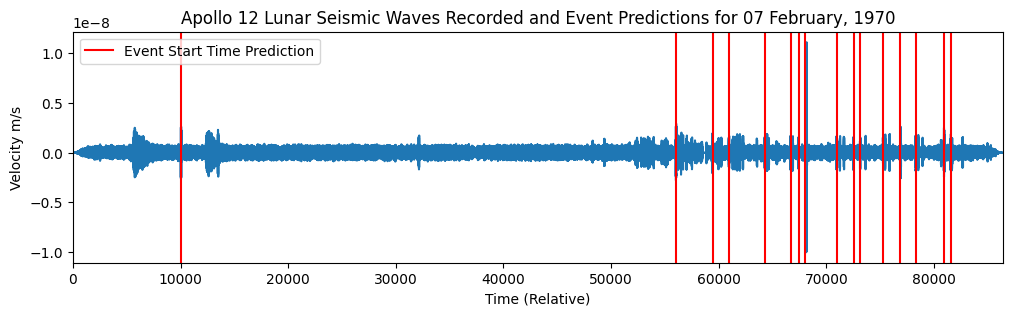

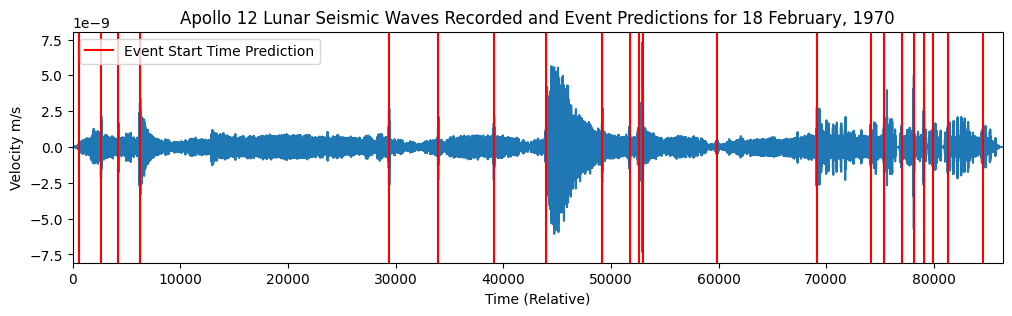

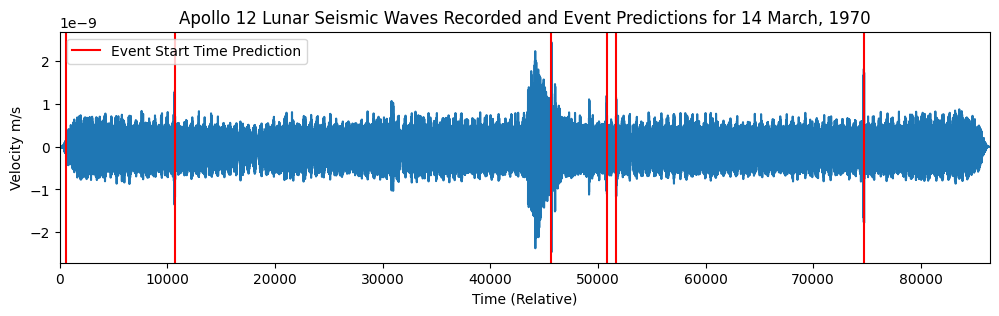

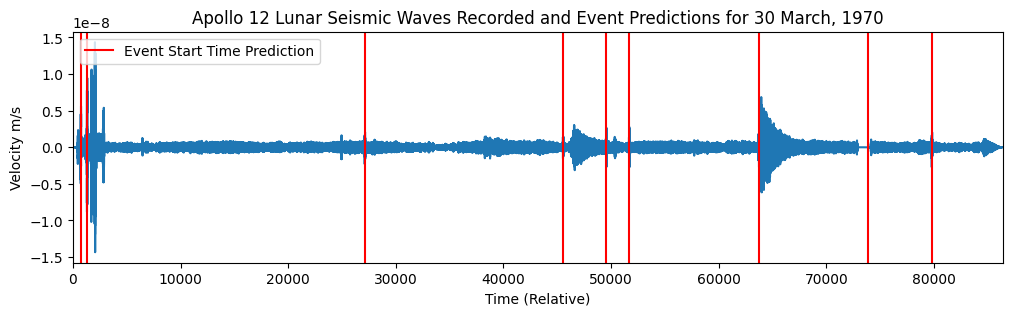

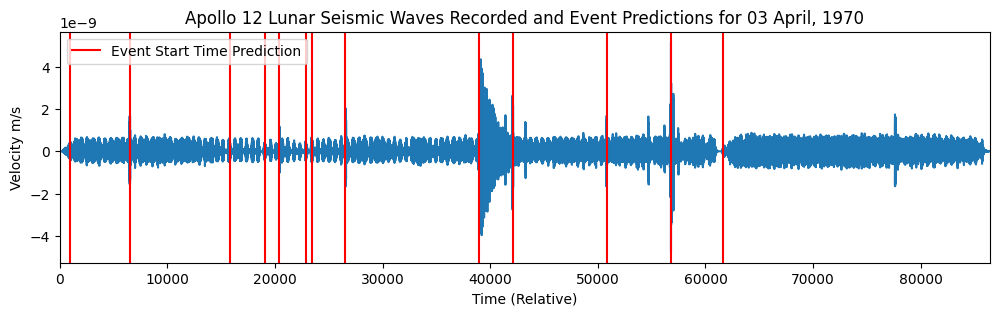

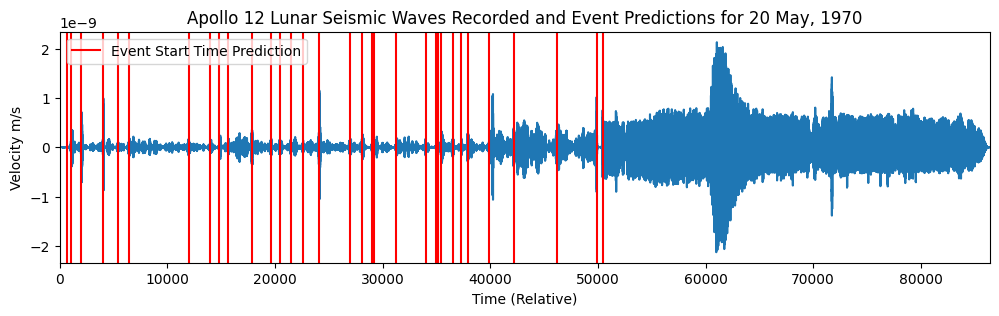

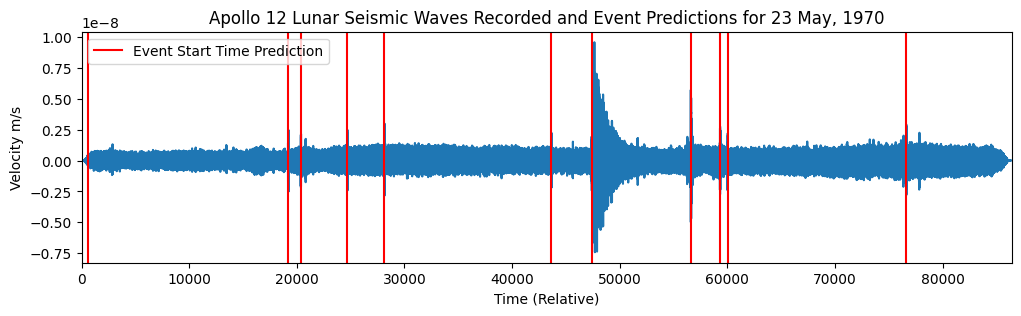

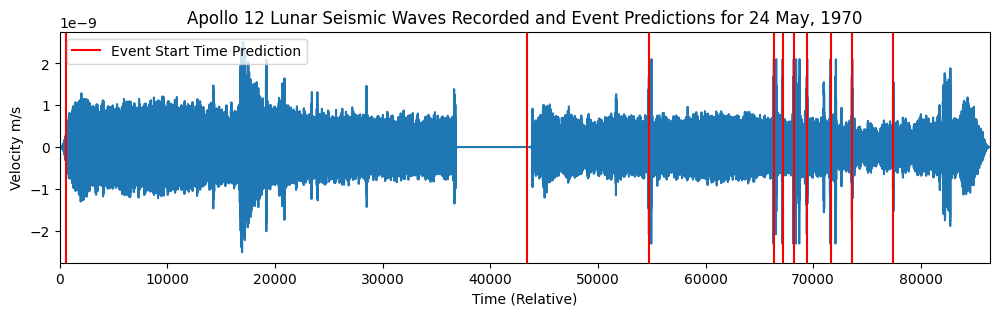

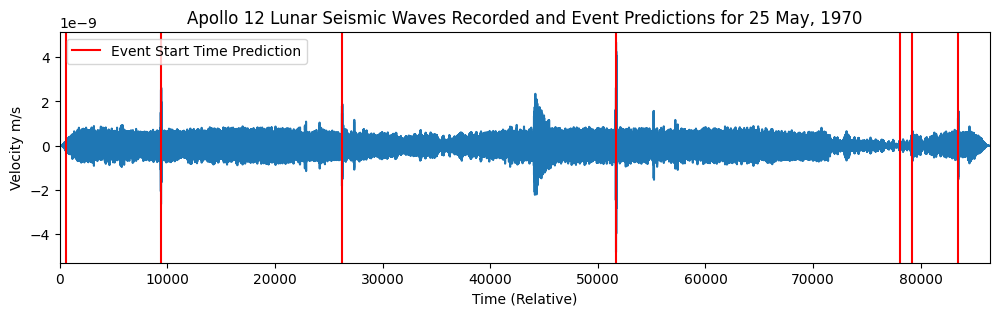

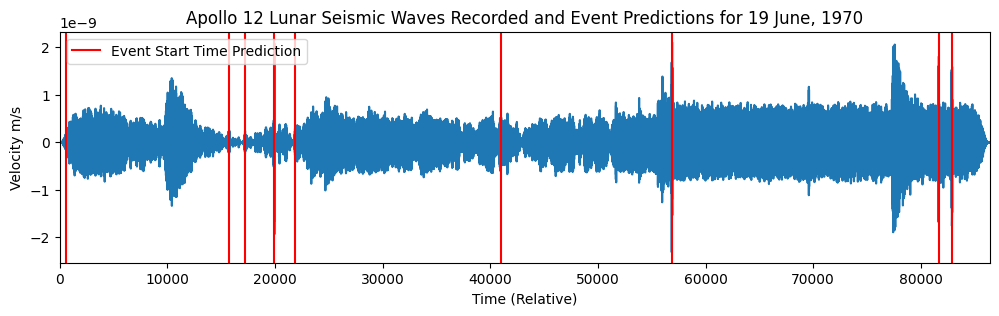

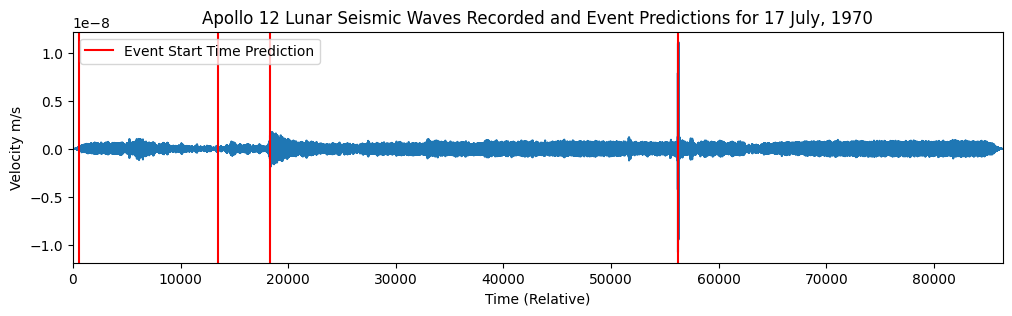

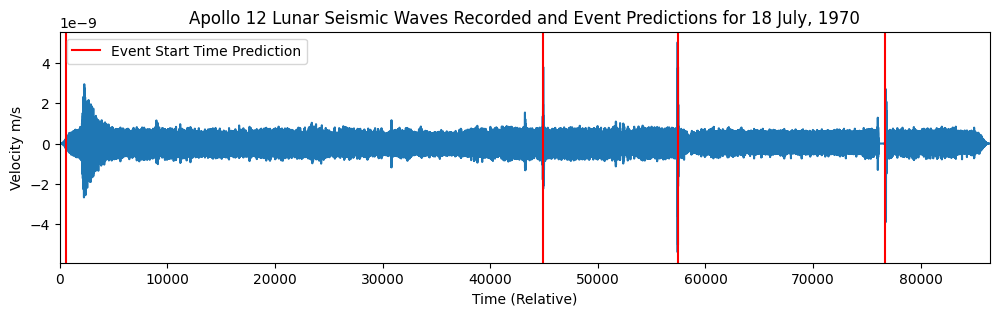

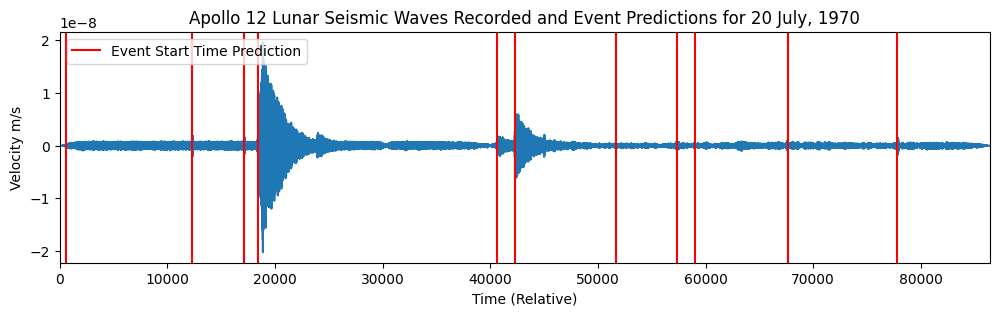

In [8]:
"""Personally, my laptop cannot handle running this whole file
so i am only running the first 15"""

lunar_test_data_directory = './space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/'
mseed_files = glob.glob(f'{lunar_test_data_directory}*.mseed')

for m_file in mseed_files[:15]:
    run_Lunar_Predictions(m_file, "Apollo 12 Lunar")

# Lunar S15 Grade B

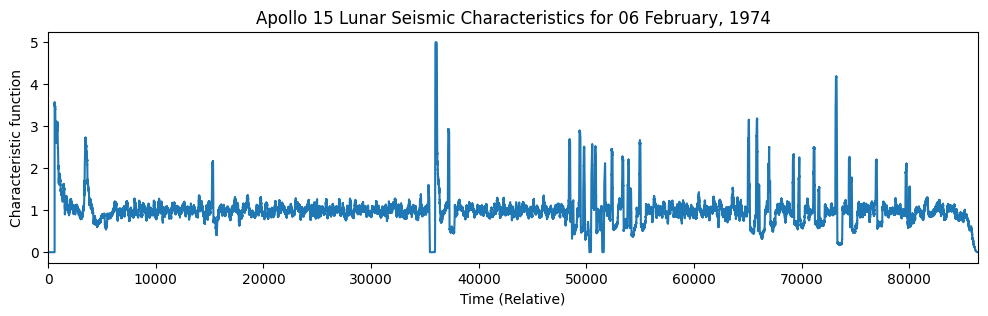

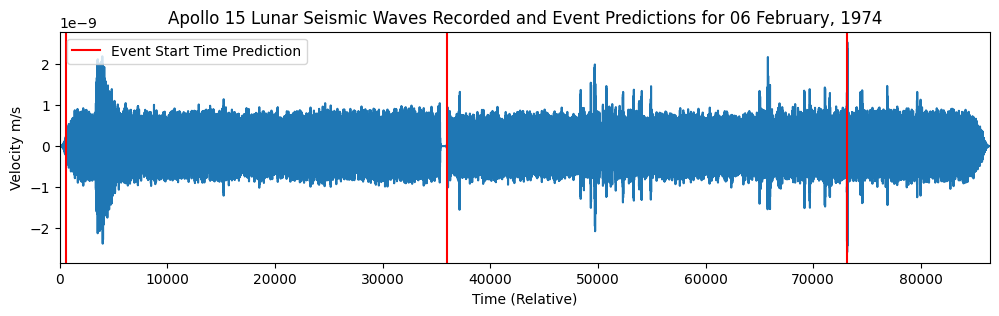

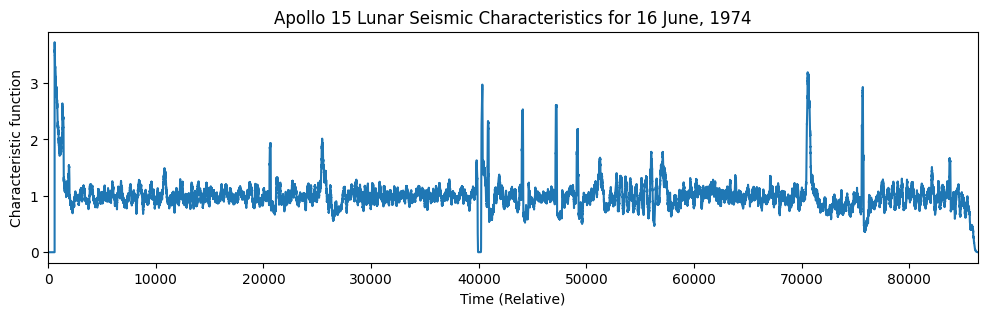

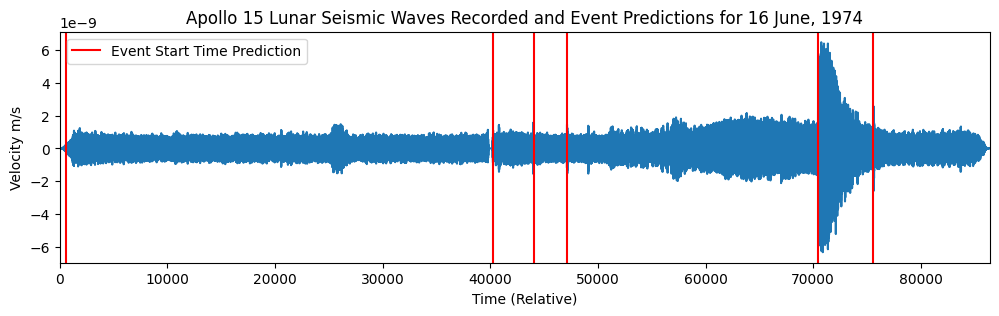

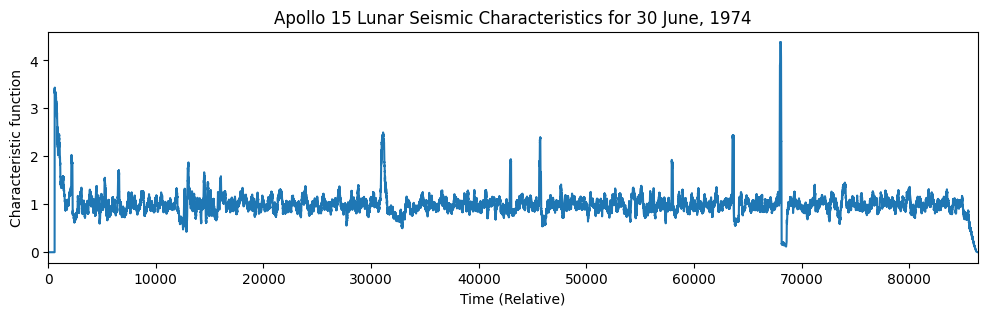

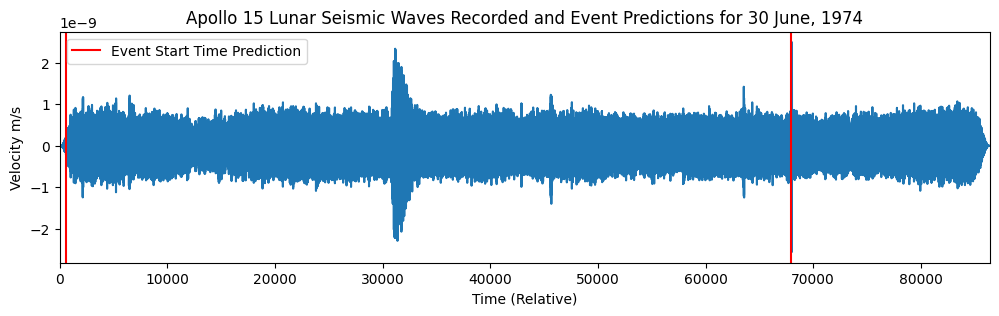

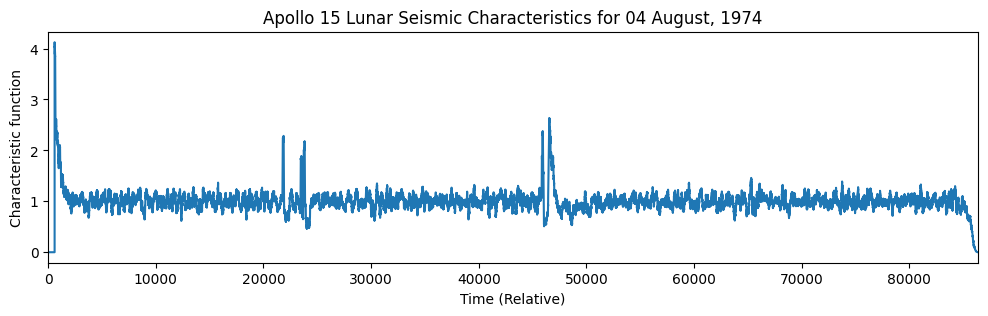

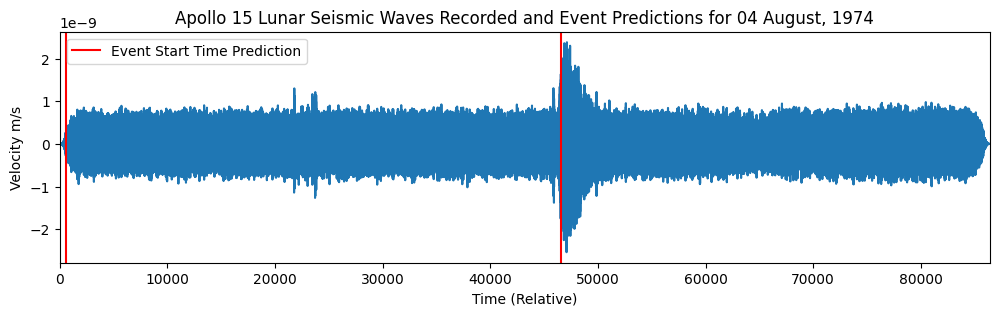

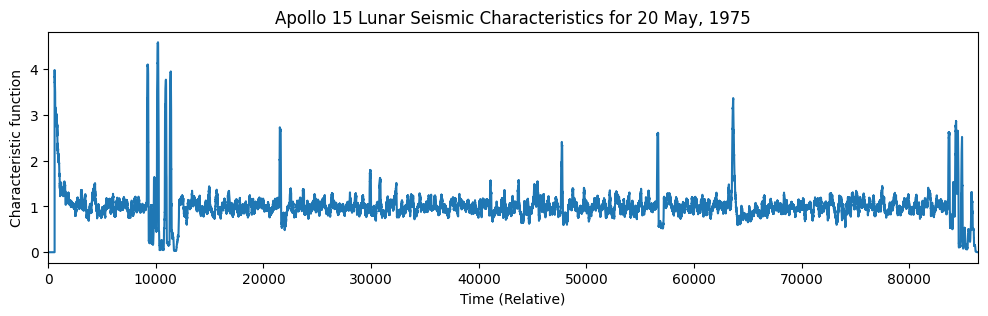

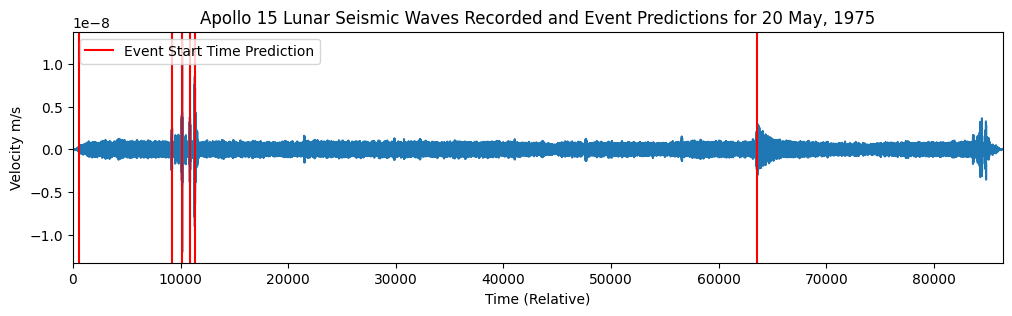

In [9]:
lunar_test_data_directory = './space_apps_2024_seismic_detection/data/lunar/test/data/S15_GradeB/'
mseed_files = glob.glob(f'{lunar_test_data_directory}*.mseed')

for m_file in mseed_files:
    run_Lunar_Predictions(m_file, "Apollo 15 Lunar", plot_char=True)

# Lunar S15 Grade A

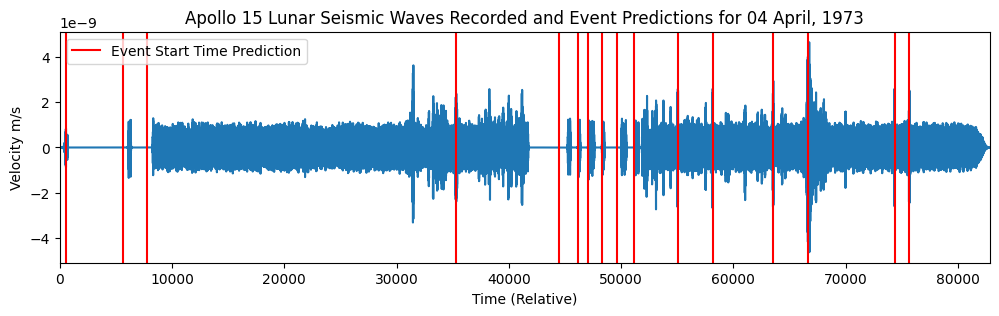

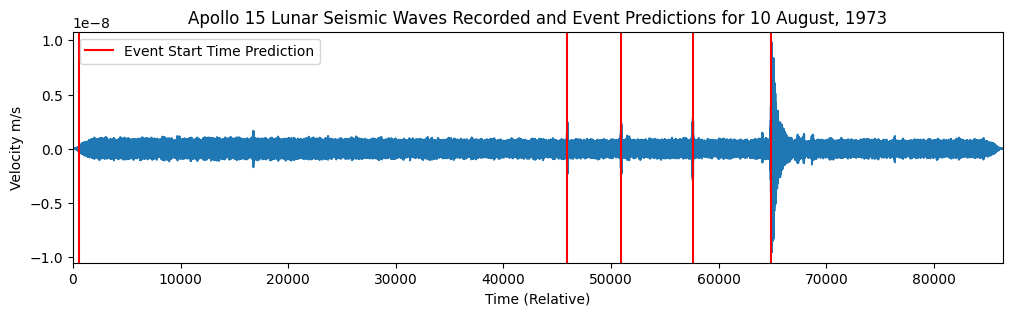

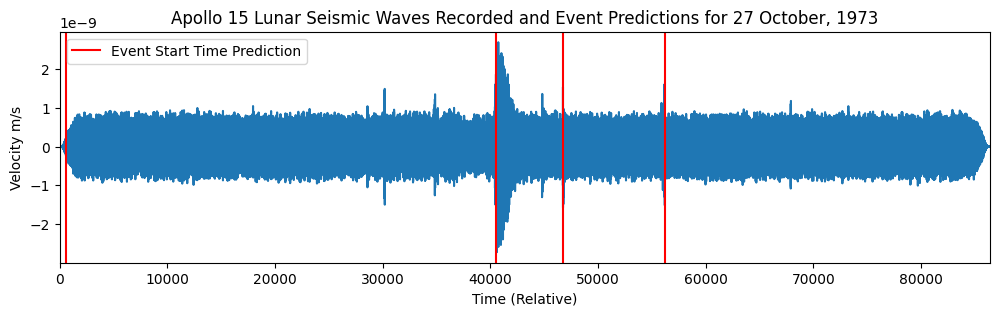

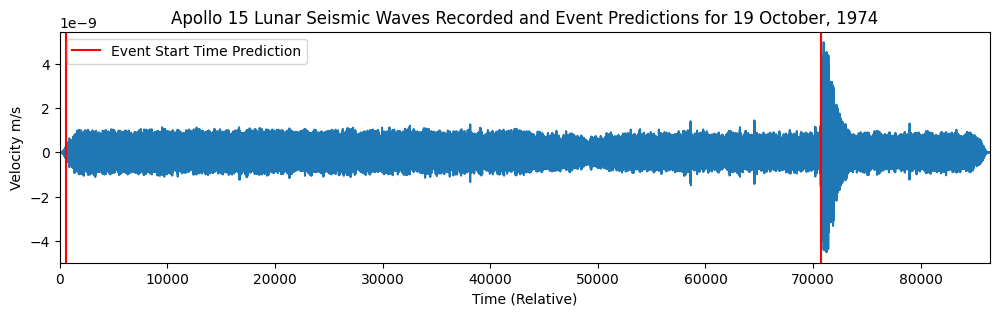

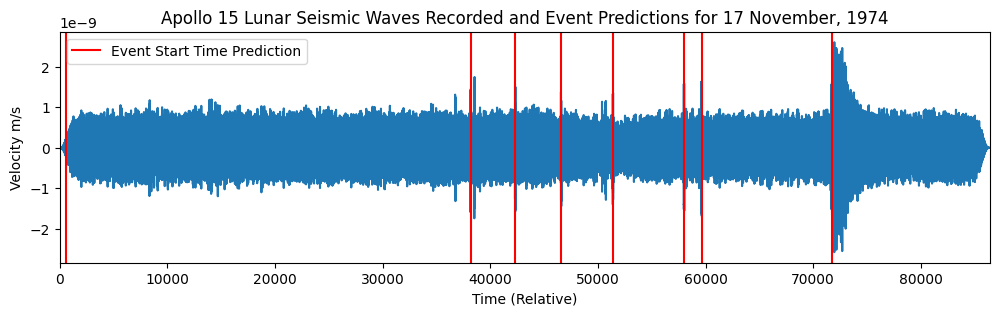

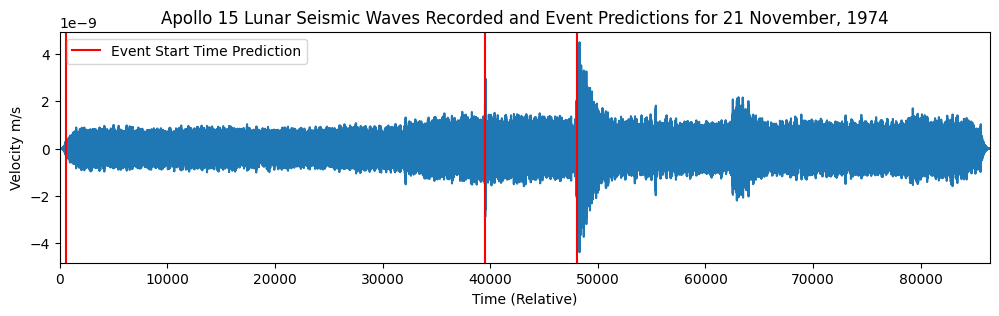

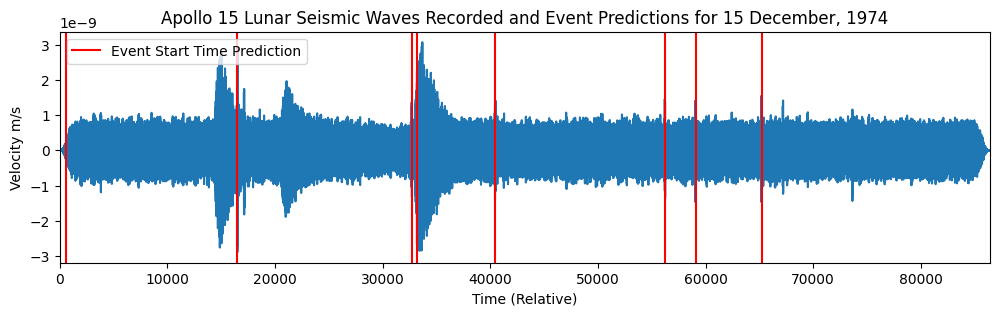

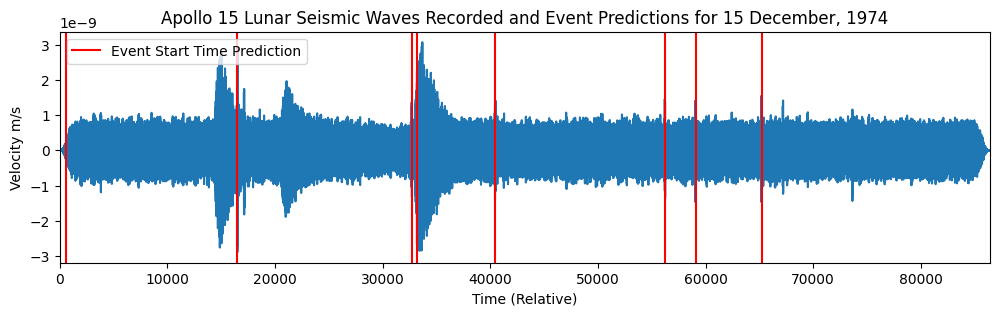

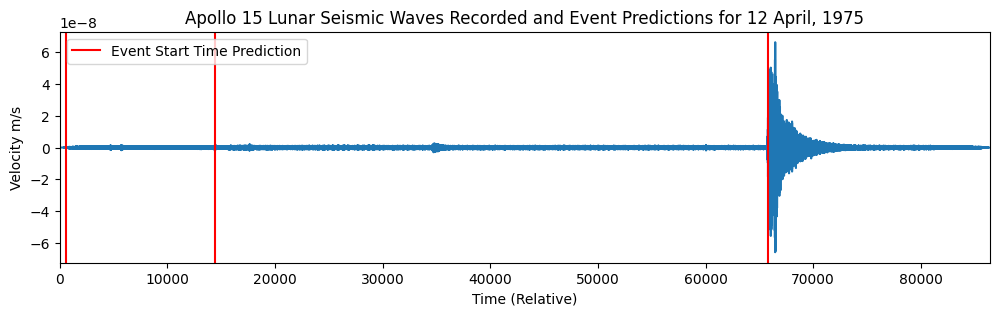

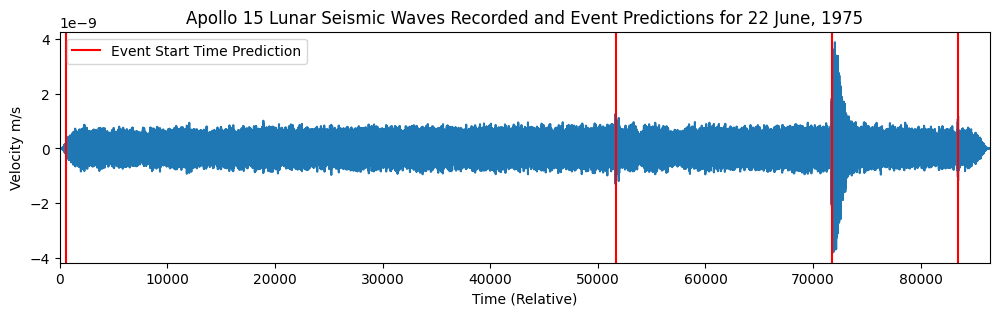

In [10]:
lunar_test_data_directory = './space_apps_2024_seismic_detection/data/lunar/test/data/S15_GradeA/'
mseed_files = glob.glob(f'{lunar_test_data_directory}*.mseed')

for m_file in mseed_files:
    run_Lunar_Predictions(m_file, "Apollo 15 Lunar")

# Lunar S16 Grade A

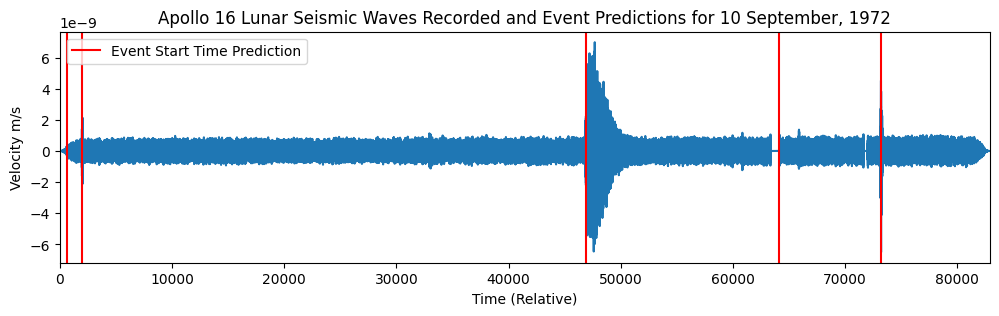

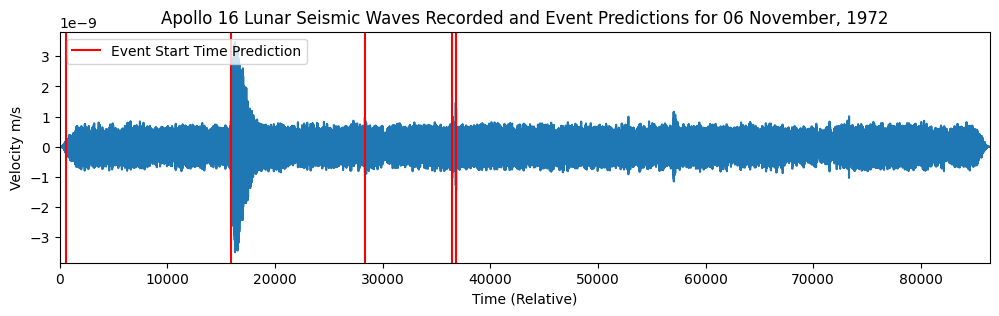

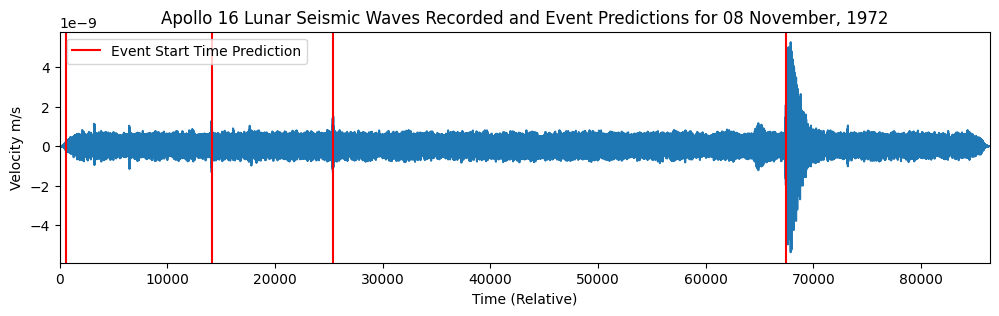

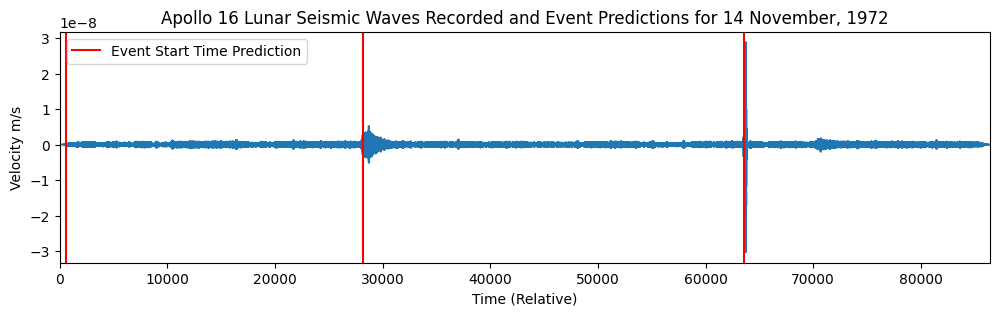

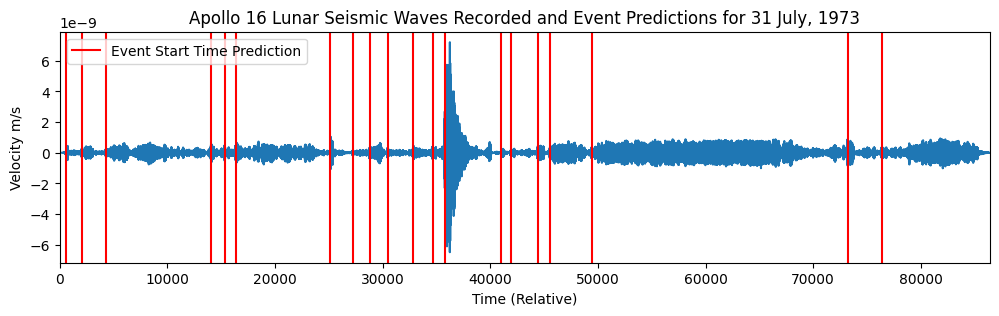

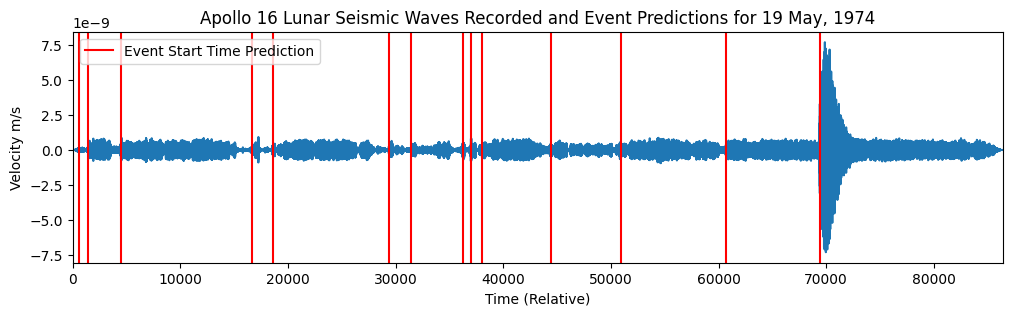

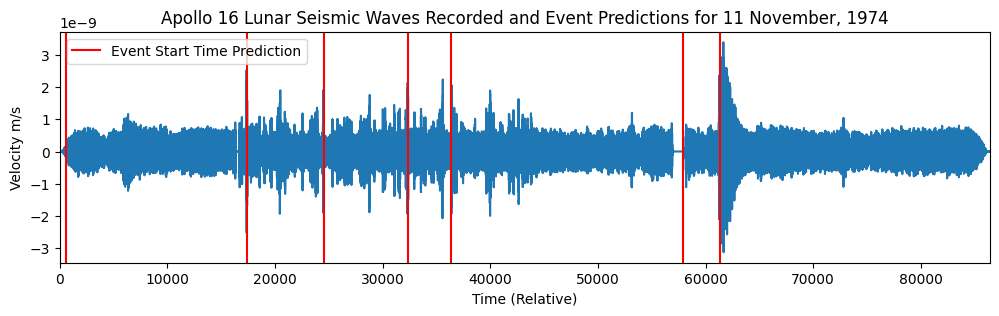

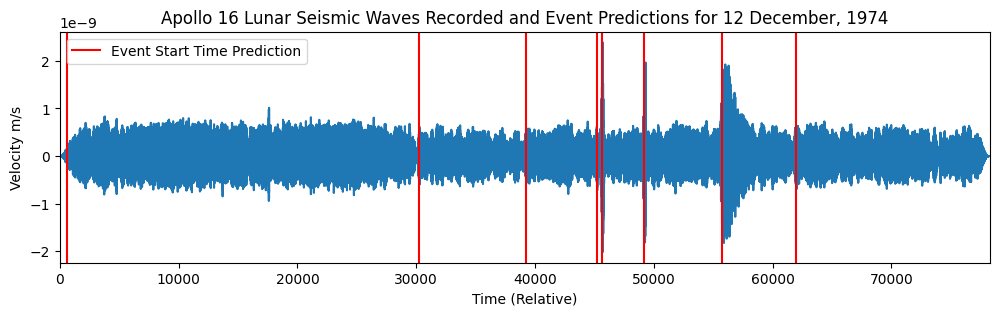

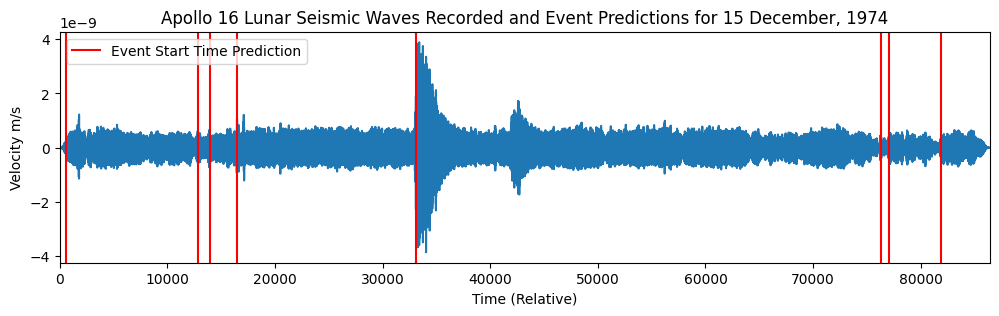

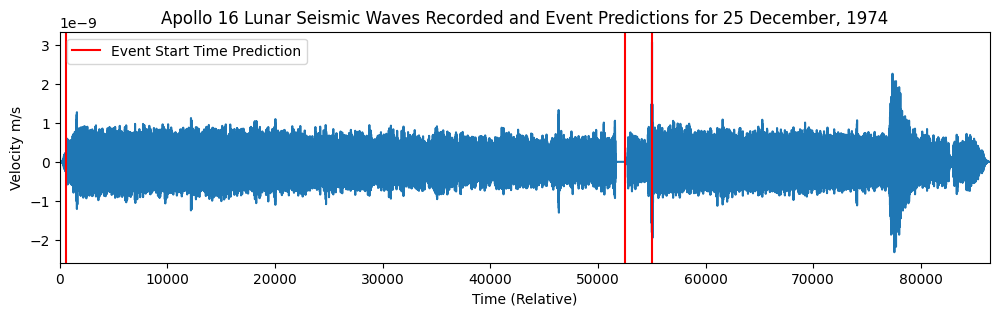

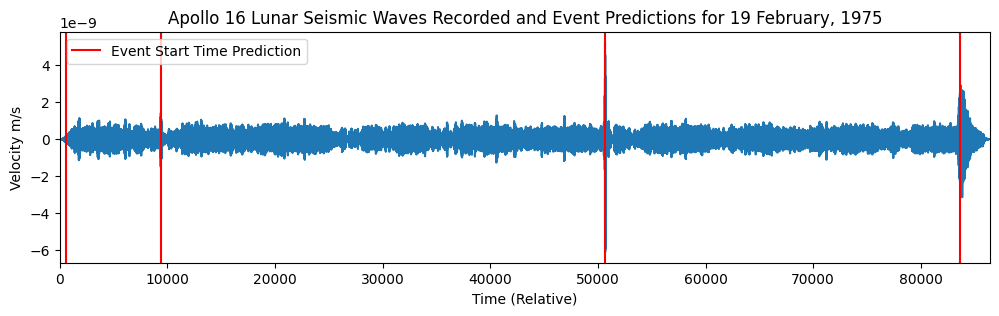

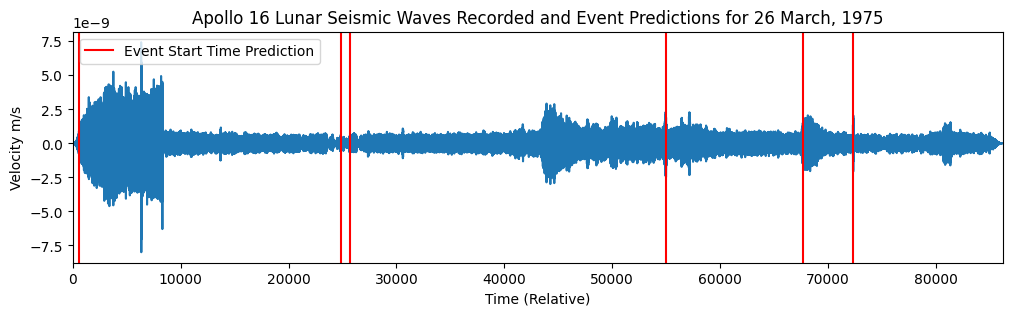

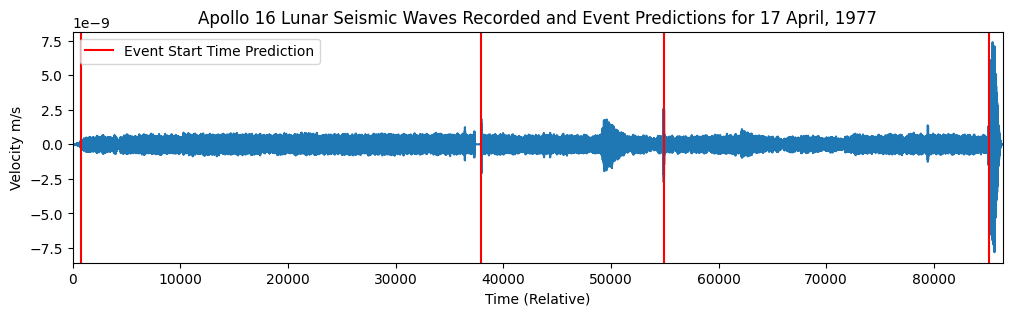

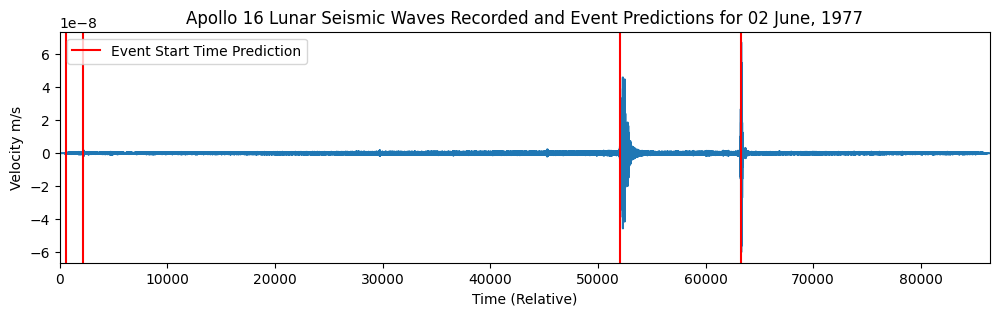

In [11]:
lunar_test_data_directory = './space_apps_2024_seismic_detection/data/lunar/test/data/S16_GradeA/'
mseed_files = glob.glob(f'{lunar_test_data_directory}*.mseed')

for m_file in mseed_files:
    run_Lunar_Predictions(m_file, "Apollo 16 Lunar")

# Lunar S16 Grade B

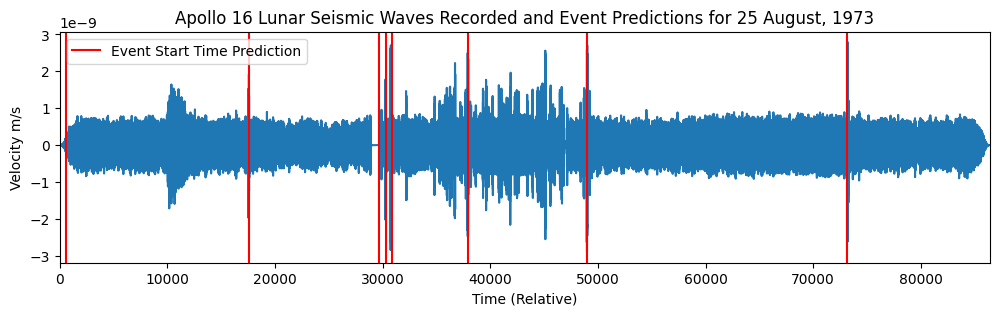

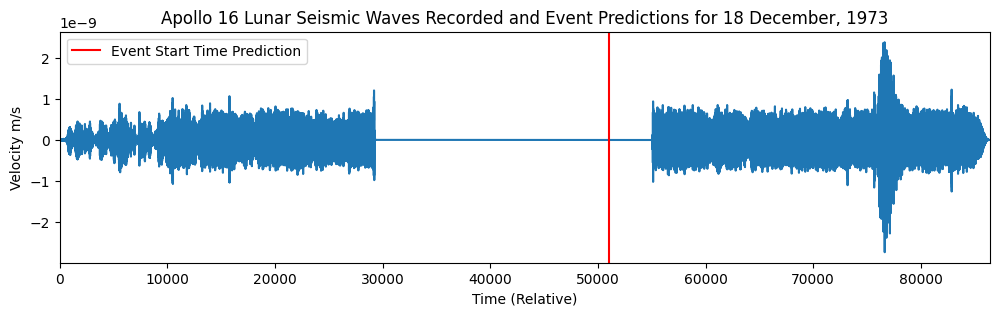

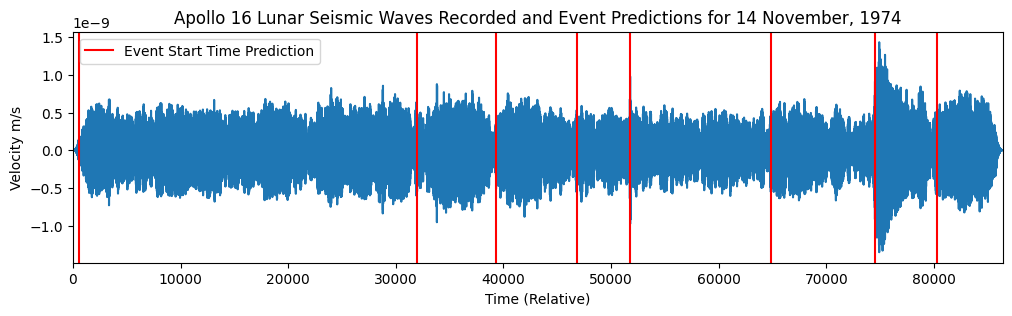

In [12]:
lunar_test_data_directory = './space_apps_2024_seismic_detection/data/lunar/test/data/S16_GradeB/'
mseed_files = glob.glob(f'{lunar_test_data_directory}*.mseed')

for m_file in mseed_files:
    run_Lunar_Predictions(m_file, "Apollo 16 Lunar")

# Mars Test

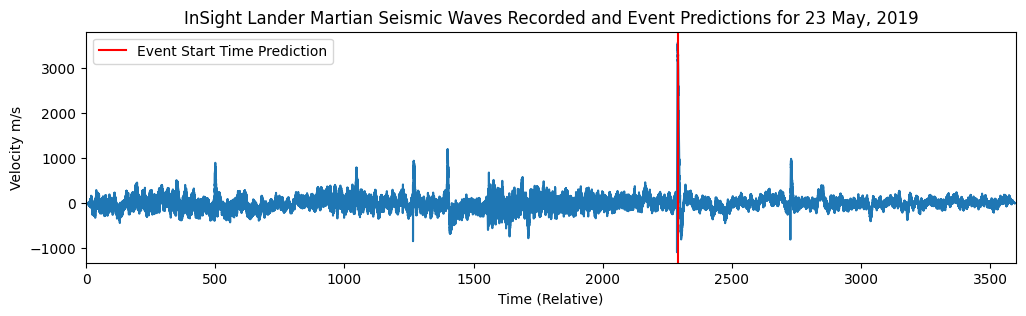

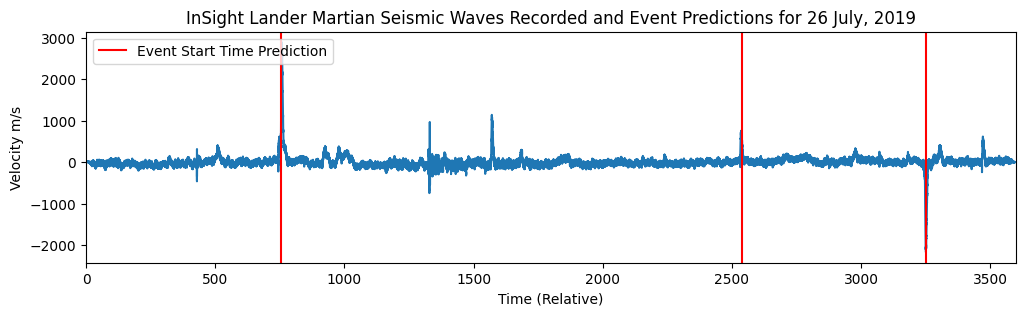

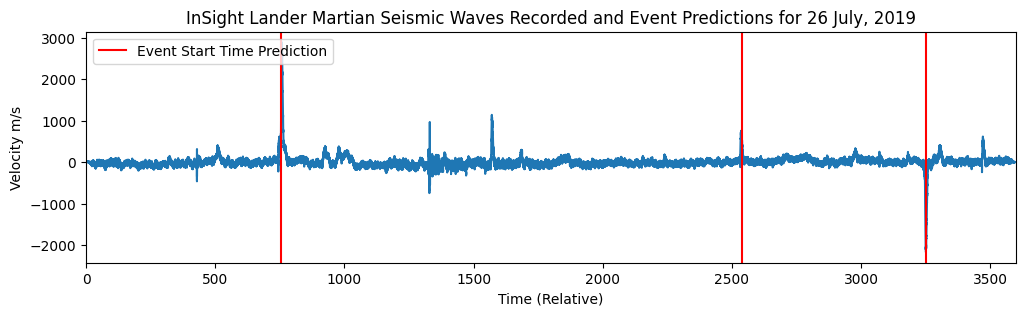

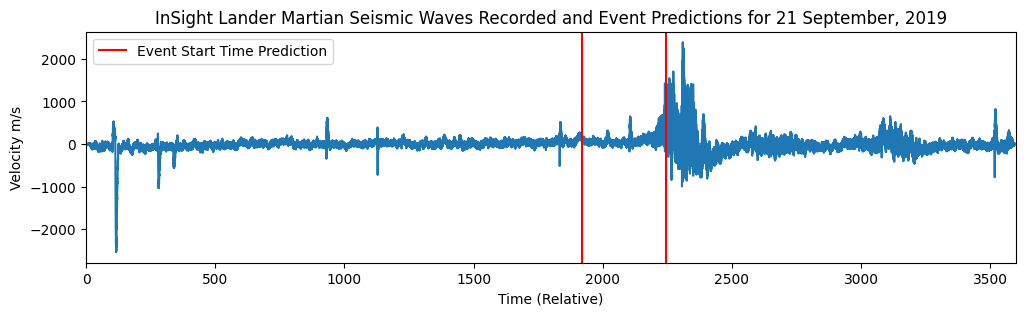

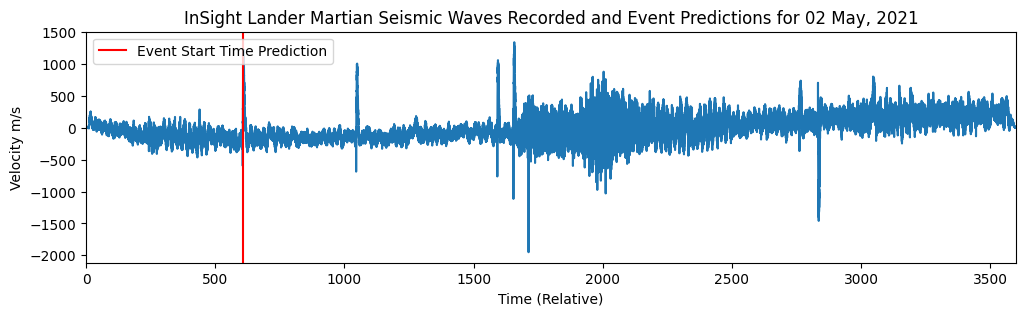

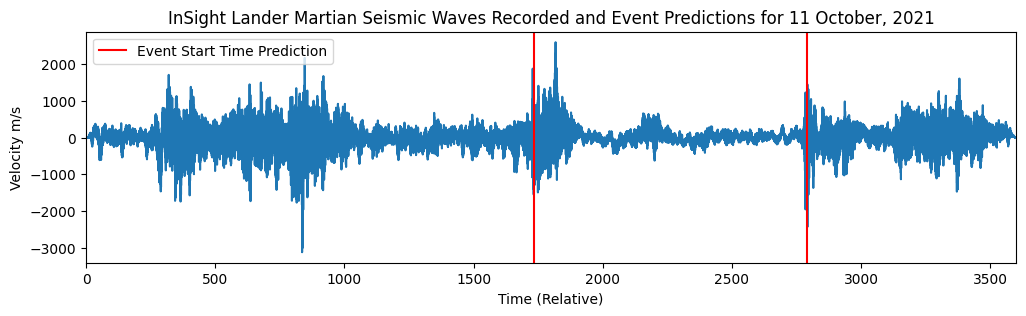

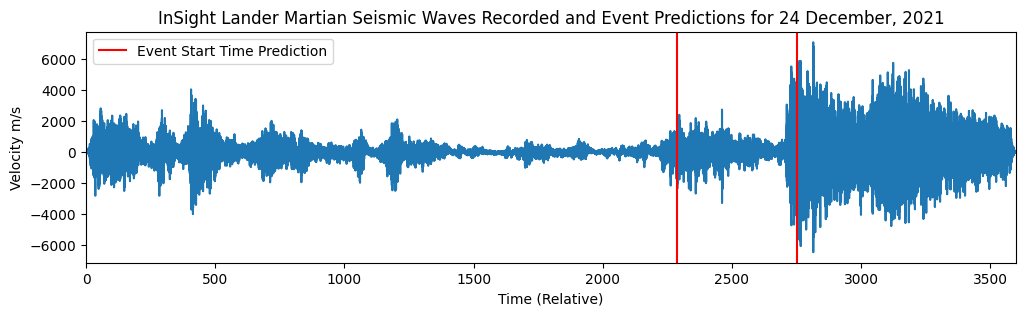

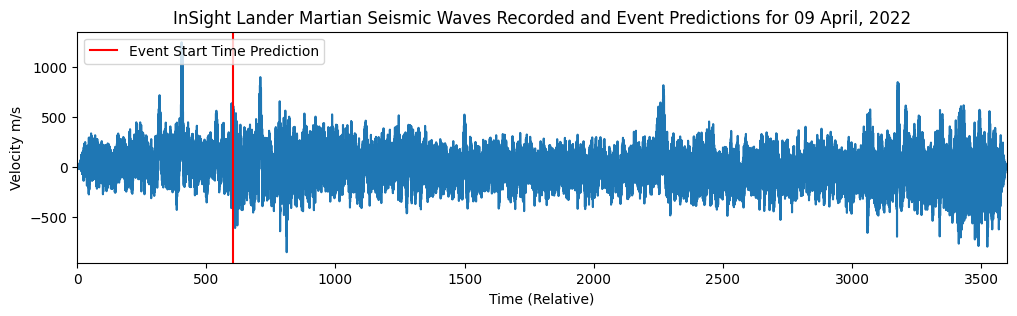

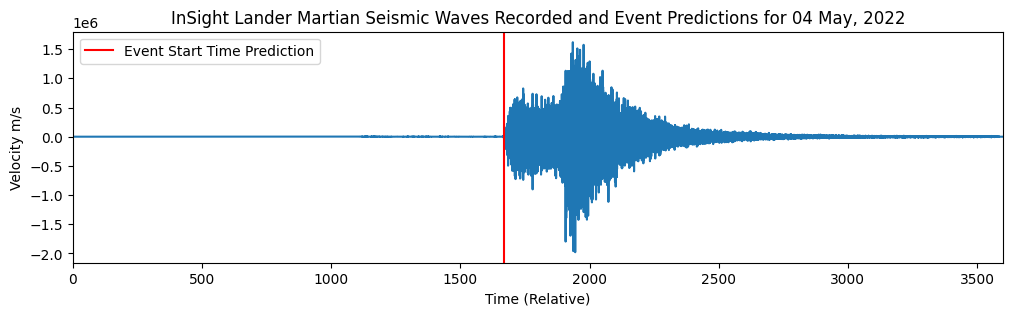

In [13]:
mars_test_data_directory = './space_apps_2024_seismic_detection/data/mars/test/data/'
mseed_files = glob.glob(f'{mars_test_data_directory}*.mseed')

for m_file in mseed_files:
    run_Lunar_Predictions(m_file, "InSight Lander Martian")